![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Final Paper Submission
# By Tatiana Bakwenye, Sebastian Boxho, Mikel Gallo and Joaquin Ossa

## Table of Contents
- [Part 0: Dataset Selection](#part-0-dataset-selection)
- [Part 1: Setting Up the Problem](#part-1-setting-up-the-problem)
  - [a. Bibliography and SOA](#a-bibliography-and-soa)
  - [b. Dataset Description](#b-dataset-description)
  - [c. Random Classifier Performance](#c-random-classifier-performance)
  - [d. Baseline Implementation](#d-baseline-implementation)
- [Part 2: Data Scientist Challenge](#part-2-data-scientist-challenge)
  - [a. BERT Model with Limited Data](#a-bert-model-with-limited-data)
  - [b. Dataset Augmentation](#b-dataset-augmentation)
  - [c. Zero-Shot Learning with LLM](#c-zero-shot-learning-with-llm)
  - [d. Data Generation with LLM](#d-data-generation-with-llm)
  - [e. Optimal Technique Application](#e-optimal-technique-application)
- [Part 3: State of the Art Comparison](#part-3-state-of-the-art-comparison)
  - [a. Full Dataset Training](#a-full-dataset-training)
  - [b. Learning Curve](#b-learning-curve)
  - [c. Technique Comparison](#c-technique-comparison)
  - [d. Methodology Analysis](#d-methodology-analysis)
- [Part 4: Model Distillation](#part-4-model-distillation)
  - [a. Model Distillation](#a-model-distillation)
  - [b. Performance and Speed Comparison](#b-performance-and-speed-comparison)
  - [c. Analysis and Improvements](#c-analysis-and-improvements)


# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [1]:
!pip install datasets
!pip install ekphrasis
!pip install langchain
!pip install transformers==4.37.2
#!pip install OpenAI

In [58]:
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from transformers import TFDistilBertModel
from keras.utils import custom_object_scope
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import random
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import string
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from spacy.matcher import Matcher, PhraseMatcher
from tensorflow.keras import regularizers
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from langchain.chat_models import ChatOpenAI
from jinja2 import Template
from langchain.prompts import (
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [3]:
### Support Functions
#python -m spacy download en_core_web_sm - Run on Terminal
nlp = spacy.load("en_core_web_sm")

# Create a new Matcher
matcher = Matcher(nlp.vocab)

## Class Proportion

def class_prop(label):
    train_class = pd.Series(label).value_counts().reset_index()
    #Rename columns
    train_class.columns = ['class', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    print(train_class[['class','count','perc']].round(4))

## Function for Based-Rule classifier
def classify_text(text):
    doc = nlp(text)
    matches = matcher(doc)
    if matches:
        return matches  # Return the label of the first match
    else:
        return "UNKNOWN"  # If no match found

## Plot Metric Results

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


### DATA EXPLORATION

def freq_table(df,label):
    train_class = df[label].value_counts().reset_index()
    #Rename columns
    train_class.columns = ['category', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    return train_class[['category','count','perc']].round(4)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Part 0: Dataset Selection

In [4]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the ne

# Part 1: Setting Up the Problem

## a. Bibliography and SOA

## b. Dataset Description

##### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.  

This dataset is an aggregation of two twitter sentiment analysis datasets:  
- University of Michigan Sentiment Analysis competition on Kaggle: https://inclass.kaggle.com/c/si650winter11  
- Twitter Sentiment Corpus by Niek Sanders: http://www.sananalytics.com/lab/twitter-sentiment/

  
Languages: English

In [5]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']


# Define the percentage of data to use
sample_percentage = 0.01

# Sample 30% of the train data
sample_size = int(len(train_data) * sample_percentage)
train_sample_indices = random.sample(range(len(train_data)), sample_size)
train_data = [train_data[i] for i in train_sample_indices]
train_labels = [train_labels[i] for i in train_sample_indices]

# Sample 30% of the validation data
sample_size = int(len(validation_data) * sample_percentage)
validation_sample_indices = random.sample(range(len(validation_data)), sample_size)
validation_data = [validation_data[i] for i in validation_sample_indices]
validation_labels = [validation_labels[i] for i in validation_sample_indices]

# Sample 30% of the test data
sample_size = int(len(test_data) * sample_percentage)
test_sample_indices = random.sample(range(len(test_data)), sample_size)
test_data = [test_data[i] for i in test_sample_indices]
test_labels = [test_labels[i] for i in test_sample_indices]


## Creating Dataframes
df_train = pd.DataFrame({'text':train_data,'label':train_labels})
df_val = pd.DataFrame({'text':validation_data,'label':validation_labels})
df_test = pd.DataFrame({'text':test_data,'label':test_labels})

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [6]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,1498,0.708
1,TEST,619,0.292
2,TOTAL,2117,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,1199,0.8
1,validation,299,0.2
2,TRAIN,1498,1.0


### Class distribution

In [7]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      1    604  0.5038
1      0    595  0.4962
validation
   class  count    perc
0      0    158  0.5284
1      1    141  0.4716
test
   class  count    perc
0      0    331  0.5347
1      1    288  0.4653


### Distribution of text lengths (train set only)

In [8]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
df_val['text_length']= [len(i.split()) for i in df_val['text']]
df_test['text_length']= [len(i.split()) for i in df_test['text']]
#Calculating Answer Length

In [9]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

['I', 'do', 'actually.', 'It', 'amazes', 'me', 'how', 'well', 'you', 'survive', 'and', 'function', 'on', 'little', 'or', 'no', 'sleep', 'at', 'all'] length:  19
['@lucullian', 'Could', 'you', 'send', 'some', 'warmth', 'to', 'us', 'in', 'chilly', 'Sweden?', 'Pliiiiiis...'] length:  12
['I', 'want', 'to', 'move', 'now...I', 'hate', 'waiting...I', "can't", 'be', 'patient.'] length:  10
['Listening', 'to', 'Alk3,', 'we', "weren't", 'that', 'bad', 'tonight', 'Daniel'] length:  9
['@AnnaXOX', 'yay', "we're", 'awsummm'] length:  4


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.884034    13.0  7.251959    1   33
1      12.928808    12.0  7.184369    1   79
   
Plot text_length distribution for positive(1) and negative(0) tweets


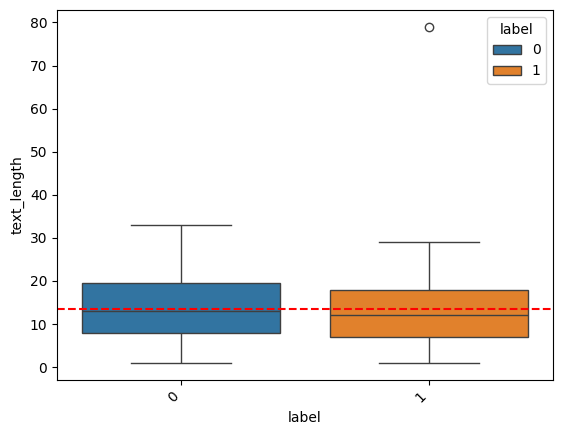

In [10]:
## Summary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

## Data Cleaning
Twitter text requires multiple transformations prior to Preprocessing

In [11]:
# Create a TextPreProcessor instance
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter="twitter",
    # corpus from which the word statistics are going to be used for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text, with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons],
    #Remove emoticon
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')]
)

# Pre-process the sentence using TextPreProcessor

def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def flatten_emotions(emotion_list):
    # Convert the list of emotions into a string
    emotion_string = ', '.join(emotion_list)
    # Use regular expression to find all words inside angle brackets
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions


def clean_text(df):
# Pre-process all the sentences in df_train['text']
    df['preprocessed_text'] = [text_processor.pre_process_doc(text) for text in df['text']]
    df['clean_text'] = df['preprocessed_text'].apply(extract_clean).apply(clean_string)

    #Getting Hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['hashtag'] = [' '.join(i) for i in df['hashtag']]

    # Iterate through the preprocessed text
    df['emotions'] = df['preprocessed_text'].apply(extract_emotions)
    df['clean_emotions'] = df['emotions'].apply(flatten_emotions)

    df = df[['text','label','text_length','clean_text','clean_emotions','hashtag']]
    return df

df_train = clean_text(df_train)
df_val = clean_text(df_val)
df_test = clean_text(df_test)


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


## DATA EXPLORATION

#### Hashtags

- 98% of the tweets have no hashtags. Most likely they have been already cleaned.
- Doesn't make sense to keep diving for more insigths.

In [12]:
hashtag_freq = freq_table(df_train,'hashtag')
hashtag_freq = hashtag_freq.sort_values(by='perc',ascending=False)
hashtag_freq['accum'] = hashtag_freq['perc'].cumsum()
print('top 10 hashtags')
display(hashtag_freq[0:10])

top 10 hashtags


,category,count,perc,accum
0,,1178,0.9825,0.9825
1,squarespace,2,0.0017,0.9842
2,1,2,0.0017,0.9859
3,IloveToronto,1,0.0008,0.9867
4,furlough,1,0.0008,0.9875
5,hhrs tcot,1,0.0008,0.9883
6,eurovision,1,0.0008,0.9891
7,furniture,1,0.0008,0.9899
8,bozeman,1,0.0008,0.9907
9,Opera,1,0.0008,0.9915


#### EMOTIONS

- 98% of the tweets have no emotions. Most likely have been already removed.
- Because they directly express the sentiment of the text, we'll concatenate them to our cleaned tweet corpus.

In [13]:
emotions_freq = freq_table(df_train,'clean_emotions')
emotions_freq = emotions_freq.sort_values(by='perc',ascending=False)
emotions_freq['accum'] = emotions_freq['perc'].cumsum()
print('top 10 emotions')
display(emotions_freq[0:10])

top 10 emotions


,category,count,perc,accum
0,,1176,0.9808,0.9808
1,wink,8,0.0067,0.9875
2,annoyed,4,0.0033,0.9908
3,sad,3,0.0025,0.9933
4,surprise,3,0.0025,0.9958
5,tong,2,0.0017,0.9975
6,happy,2,0.0017,0.9992
7,laugh,1,0.0008,1.0000


In [14]:
#Concatenate text with emotions
df_train['text_emotion'] = df_train['clean_text']+' '+df_train['clean_emotions']
df_val['text_emotion'] = df_val['clean_text']+' '+df_val['clean_emotions']
df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


### Preprocessor

In [15]:
#Defining preprocessing class to be included in Pipeline later.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


## Text mining - Preprocessing, CountVectorizing and tf-idf

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Convert text to lowercase
            #text = text.lower()
            text = "".join([char.lower() for char in text if char not in string.punctuation])
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords and apply lemmatization
            filtered_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
            # Join tokens back into a string
            preprocessed_text = ' '.join(filtered_tokens)
            preprocessed_texts.append(preprocessed_text)

        return preprocessed_texts


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
sent = ['hello . ! my name is! test .. wuhoo']
pre =TextPreprocessor()
pre.fit(sent)
res = pre.transform(sent)
res

['hello name test wuhoo']

#### Exploring positive and negative words using WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


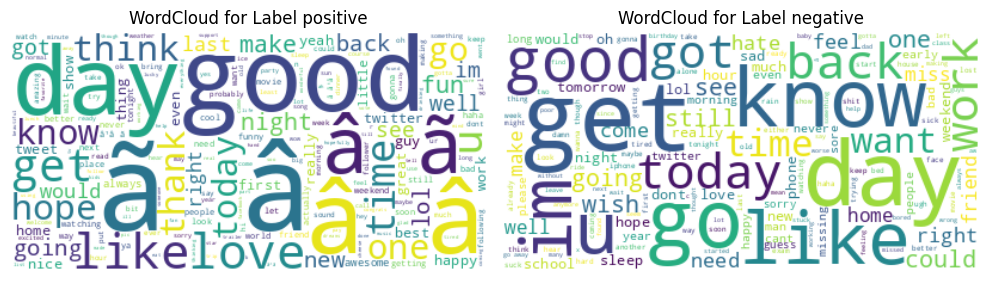

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['clean_text'], df_train['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exploring positive and negative words using TF-IDF + LDA

In [18]:
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train['clean_text'])



Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

### TF-IDF Score

In [19]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

276


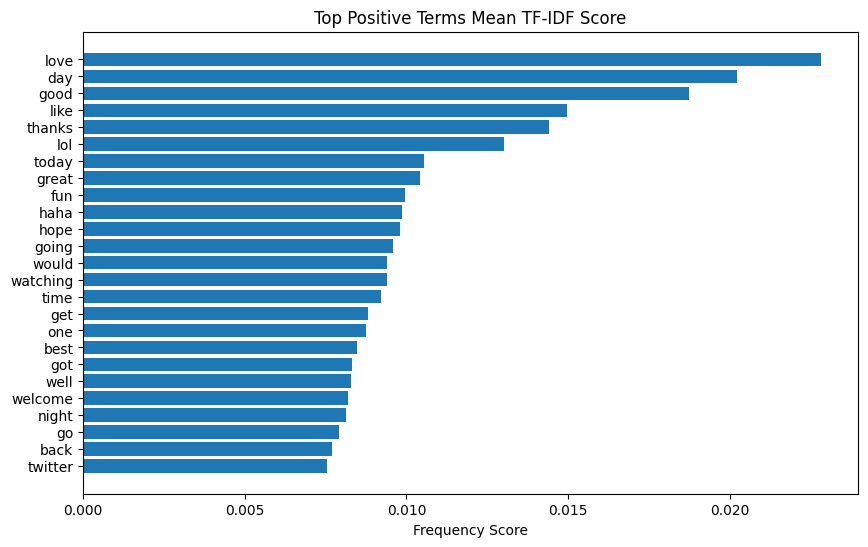

In [20]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

276


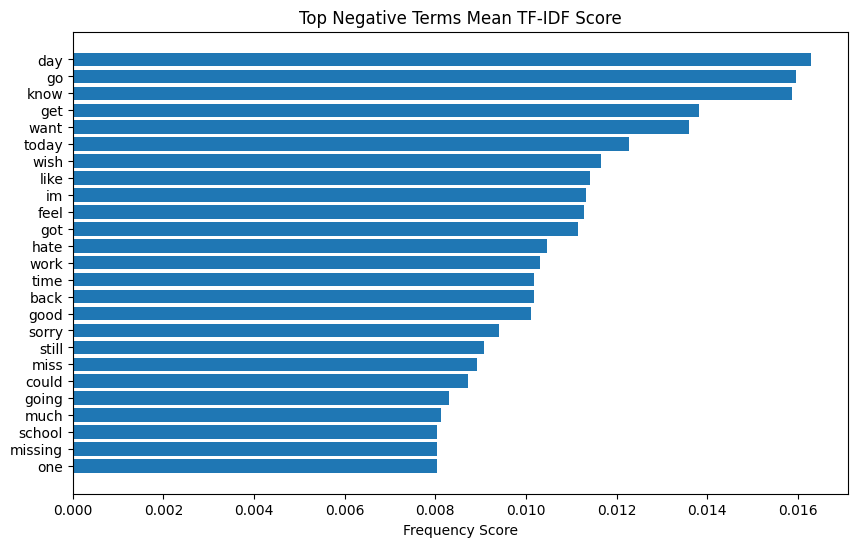

In [21]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

### Analyzing Both Positive and Negative Most Common Topics

In [22]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_pos_matrix = pipeline.transform(df_train[df_train['label']==1]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=pos_feature_names)

# Fit the model to your TF-IDF matrix
lda.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


# Print top words for each topic
print_top_words(lda, pos_feature_names, n_top_words=10)

Topic #1: welcome, funny, yes, movie, put, lol, hey, watch, much, tomorrow
Topic #2: going, tweet, twitter, ah, need, many, work, finished, use, party
Topic #3: good, today, one, see, way, haha, know, get, ok, ya
Topic #4: great, dont, even, xx, omg, baby, little, day, music, next
Topic #5: lol, look, course, thank, probably, wow, like, someone, sound, another
Topic #6: day, thanks, best, people, nice, place, world, hi, following, follower
Topic #7: fun, back, watching, good, night, well, morning, got, old, really
Topic #8: amazing, always, could, tonight, awesome, friend, bad, check, done, keep
Topic #9: love, right, new, ice, bring, cool, yay, wait, soon, never
Topic #10: like, would, hope, go, time, happy, sun, guy, yeah, make


In [24]:
def get_top_words(model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Get top words for each topic
top_words_per_topic = get_top_words(lda, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_pos_words = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_pos = set(top_pos_words)

In [25]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda2 = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_neg_matrix = pipeline.transform(df_train[df_train['label']==0]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_neg_matrix.toarray(), columns=neg_feature_names)

# Fit the model to your TF-IDF matrix
lda2.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [26]:
# Print top words for each topic
print_top_words(lda2, neg_feature_names, n_top_words=10)

Topic #1: see, school, face, need, thing, wanted, thanks, nothing, please, nice
Topic #2: day, going, dont, got, last, like, ah, good, lol, seems
Topic #3: know, missing, get, never, people, haha, hear, new, help, least
Topic #4: wish, back, miss, today, could, come, really, cant, guess, baby
Topic #5: go, oh, tonight, still, work, hope, another, already, get, sad
Topic #6: morning, love, twitter, one, everyone, hard, talking, feeling, guy, dad
Topic #7: much, well, either, mom, night, something, way, happy, thats, start
Topic #8: hate, home, time, trying, tired, make, bad, sore, long, school
Topic #9: want, feel, bored, alone, always, mean, iphone, would, everything, like
Topic #10: sorry, im, like, worst, hot, working, year, suck, aw, weekend


In [27]:
# Get top words for each topic
topneg_words_per_topic = get_top_words(lda2, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_neg_words = [word for sublist in topneg_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_neg = set(top_neg_words)

## c. Random Classifier Performance

**pending**: include preprocessing in the pipeline to properly treat tweets.

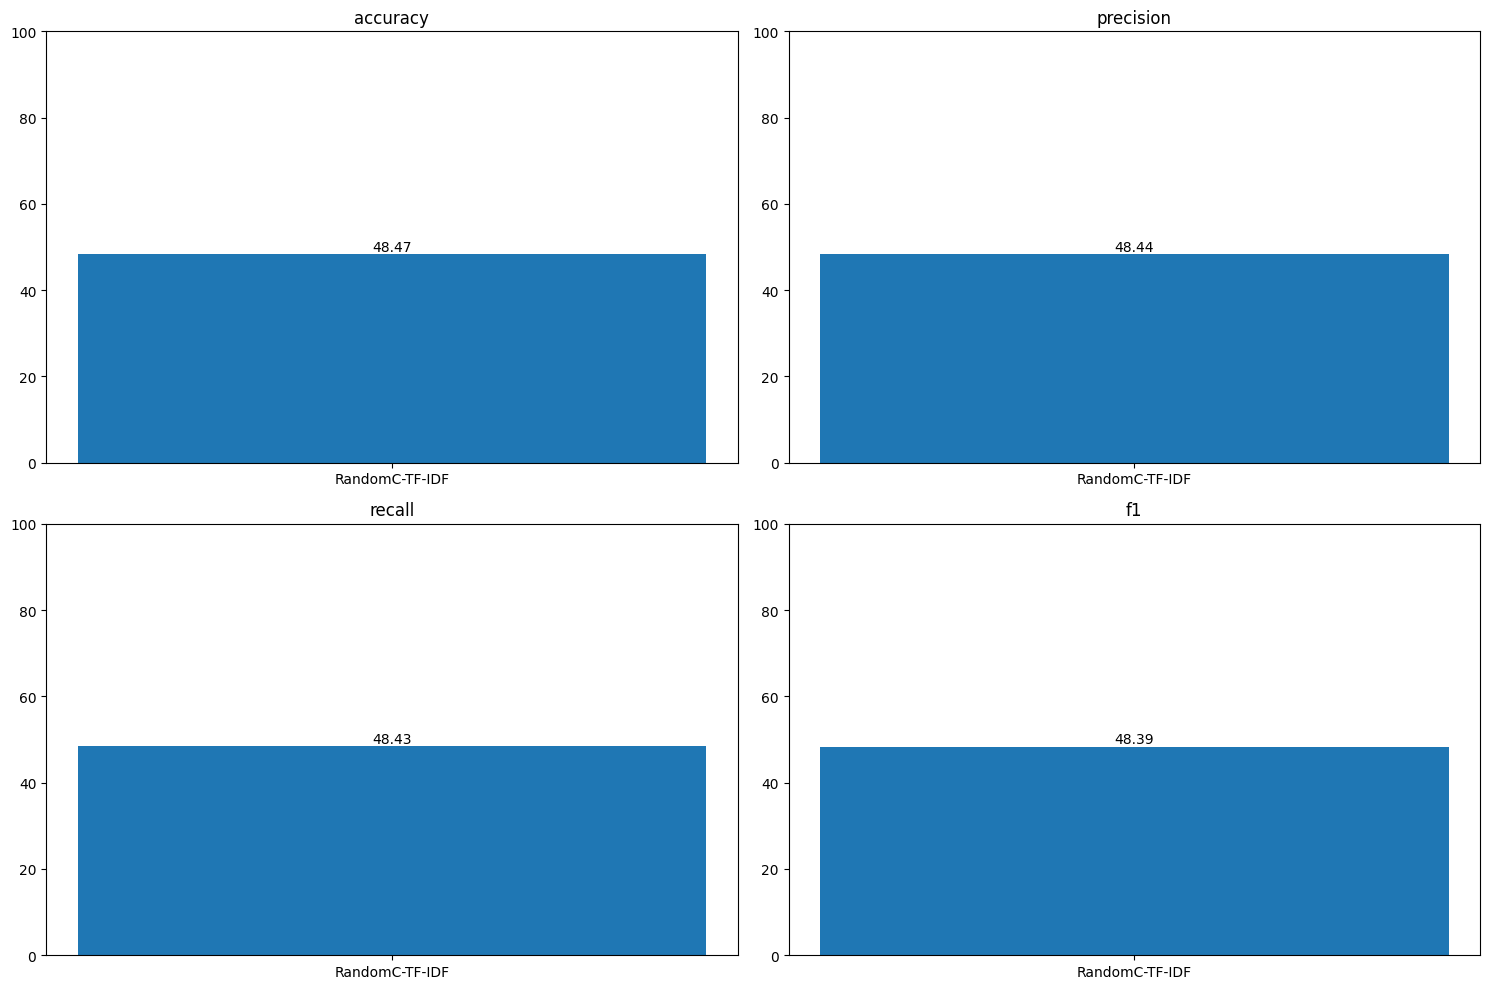

In [28]:
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the classifier to the training data
pipeline.fit(df_train['clean_text'])
##Creating matrix
tf_idf_matrix = pipeline.transform(df_train['clean_text'])
val_idf_matrix = pipeline.transform(df_test['clean_text']) #Changed validation for test
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())
val_mtx = pd.DataFrame(data=val_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())

##Innitializing RandomClassifier
dummy_classifier = DummyClassifier(strategy='uniform')
# Fit the classifier to the training data
dummy_classifier.fit(tfidf_mtx, df_train['label'])

# Make predictions on the testing data
y_pred = dummy_classifier.predict(val_mtx)

# Calculate accuracy (or any other metric)
metrics_val= Metrics()
metrics_val.run(test_labels, y_pred, "RandomC-TF-IDF")
metrics_val.plot()


## d. Baseline Implementation

### Rule-Based using Spacy Matcher

In [29]:
## Call positive words from Positive LDA
print(unique_pos)

{'put', 'done', 'thanks', 'bad', 'ice', 'haha', 'time', 'could', 'yes', 'bring', 'another', 'hope', 'got', 'tomorrow', 'work', 'hey', 'funny', 'would', 'party', 'watch', 'way', 'use', 'probably', 'friend', 'baby', 'check', 'someone', 'next', 'lol', 'morning', 'follower', 'good', 'finished', 'one', 'today', 'ok', 'like', 'going', 'world', 'well', 'tonight', 'soon', 'watching', 'make', 'always', 'best', 'keep', 'dont', 'wow', 'fun', 'right', 'yay', 'get', 'music', 'night', 'amazing', 'much', 'thank', 'day', 'guy', 'people', 'happy', 'many', 'wait', 'know', 'back', 'welcome', 'following', 'need', 'place', 'sound', 'old', 'ya', 'hi', 'new', 'little', 'sun', 'ah', 'xx', 'love', 'course', 'cool', 'never', 'really', 'awesome', 'yeah', 'movie', 'tweet', 'even', 'see', 'nice', 'omg', 'twitter', 'great', 'go', 'look'}


In [30]:
## Get all the most relevant positive terms
positives = ['cute','aw','best','happy','haha',
             'amazing','fun','great','yay','love',
             'lol','excited','awesome','wow','nice','beautiful',
             'cool','glad','good']

print(positives)

['cute', 'aw', 'best', 'happy', 'haha', 'amazing', 'fun', 'great', 'yay', 'love', 'lol', 'excited', 'awesome', 'wow', 'nice', 'beautiful', 'cool', 'glad', 'good']


In [31]:
## Call negative words from Negative LDA
print(unique_neg)

{'thanks', 'bad', 'haha', 'time', 'could', 'last', 'dad', 'another', 'hope', 'got', 'help', 'everything', 'work', 'year', 'hot', 'would', 'least', 'way', 'hate', 'guess', 'im', 'baby', 'come', 'school', 'lol', 'morning', 'suck', 'good', 'one', 'today', 'like', 'tired', 'going', 'worst', 'weekend', 'home', 'everyone', 'tonight', 'feeling', 'sad', 'well', 'either', 'make', 'missing', 'working', 'always', 'sorry', 'mom', 'mean', 'oh', 'dont', 'face', 'sore', 'want', 'get', 'already', 'night', 'much', 'something', 'day', 'guy', 'people', 'happy', 'talking', 'iphone', 'alone', 'feel', 'know', 'back', 'wanted', 'thats', 'hear', 'bored', 'trying', 'long', 'nothing', 'need', 'hard', 'cant', 'new', 'please', 'still', 'ah', 'love', 'never', 'seems', 'really', 'miss', 'aw', 'wish', 'see', 'thing', 'nice', 'twitter', 'go', 'start'}


In [32]:
## Get all the most relevant negative terms
negatives = ['sick','hurt','tired','hate','bad',
             'damn','never','miss','suck','sorry',
             'ugh','sad','lost', 'bored']

print(negatives)

['sick', 'hurt', 'tired', 'hate', 'bad', 'damn', 'never', 'miss', 'suck', 'sorry', 'ugh', 'sad', 'lost', 'bored']


### Implement rule-based conditions for our baseline model

In [33]:
#loading and initializing nlp object
nlp = spacy.load('en_core_web_sm')
## Initializing Matcher
matcher = Matcher(nlp.vocab)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [34]:
## Initializing Matcher
matcher = Matcher(nlp.vocab)

# based on word cloud
positive_patterns = [
    [{'LOWER': 'cute'}],
    [{'LOWER': 'aw'}],
    [{'LOWER': 'best'}],
    [{'LOWER': 'happy'}],
    [{'LOWER': 'haha'}],
    [{'LOWER': 'amazing'}],
    [{'LOWER': 'fun'}],
    [{'LOWER': 'great'}],
    [{'LOWER': 'yay'}],
    [{'LOWER': 'love'}],
    [{'LOWER': 'lol'}],
    [{'LOWER': 'excited'}],
    [{'LOWER': 'awesome'}],
    [{'LOWER': 'wow'}],
    [{'LOWER': 'nice'}],
    [{'LOWER': 'beautiful'}],
    [{'LOWER': 'cool'}],
    [{'LOWER': 'glad'}],
    [{'LOWER': 'good'}]
]


# based on word cloud
negative_patterns = [
    [{'LOWER': 'sick'}],
    [{'LOWER': 'hurt'}],
    [{'LOWER': 'tired'}],
    [{'LOWER': 'hate'}],
    [{'LOWER': 'bad'}],
    [{'LOWER': 'damn'}],
    [{'LOWER': 'never'}],
    [{'LOWER': 'miss'}],
    [{'LOWER': 'suck'}],
    [{'LOWER': 'sorry'}],
    [{'LOWER': 'ugh'}],
    [{'LOWER': 'sad'}],
    [{'LOWER': 'lost'}],
    [{'LOWER': 'bored'}]
]


## Adding patterns to matcher
matcher.add('positives',positive_patterns)
matcher.add('negatives',negative_patterns)


In [35]:
#Matching elements in documents
## Matching VALIDATION
docs_v = [nlp(doc) for doc in df_test['clean_text']]
matches_v = [matcher(d) for d in docs_v]

In [36]:
def matching_func(d,ms):
    #Return the index and the total number of matches per row
    rows_data = []
    for (i, match),doc in zip(enumerate(ms),d):
        #variables for defining current row/index
        row = 0
        row=i
        # positive variables
        positives = 0
        pos_w = []
        # negative variables
        negatives = 0
        neg_w = []

        diction = {'index':0,'total':0, 'positive':0 ,'negative':0,'pos_words':[],'neg_words':[]}
        # Filling dictionary
        diction['index'] = row
        diction['total'] = len(match)

        for match_id, start, end in match:
            if nlp.vocab.strings[match_id] == "positives":
                # store positive matched words
                pos_words = doc[start:end].text
                pos_w.append(pos_words)
                #diction['pos_words'] = pos_w
                # store number of positive words
                positives = len(pos_w)
                diction['positive'] = positives
            elif nlp.vocab.strings[match_id] == "negatives":
                # store negative matched words
                neg_words = doc[start:end].text
                neg_w.append(neg_words)
                #diction['neg_words'] = neg_w
                # store number of negative words
                negatives = len(neg_w)
                diction['negative'] = negatives

        #Add words matched to dictionary
        diction['pos_words'] = pos_w
        #diction['positive'] = positives
        diction['neg_words'] = neg_w
        #diction['negative'] = negatives

        diction = {k: np.nan if (not v and v != 0) else v for k, v in diction.items()}

        rows_data.append(diction)

    df = pd.DataFrame(rows_data)
    return df
        #print(diction['index'],' ',diction['total'],' ',diction['pos_words'],' ',diction['positive'],' ',diction['neg_words'],' ',diction['negative'])

In [37]:
va_df = matching_func(docs_v,matches_v)
va_df

,index,total,positive,negative,pos_words,neg_words
0,0,1,1,0,[great],NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
614,614,2,0,2,NaN,"[sad, lost]"
615,615,0,0,0,NaN,NaN
616,616,0,0,0,NaN,NaN
617,617,0,0,0,NaN,NaN


In [38]:
# Create a new column 'proba' where 1 is returned if positives are greater than negatives, else 0
threshold = 0.5

va_df['proba'] = np.where(va_df['total'] != 0, (va_df['positive'] / va_df['total']) > threshold, 0)
va_df

,index,total,positive,negative,pos_words,neg_words,proba
0,0,1,1,0,[great],NaN,1
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
614,614,2,0,2,NaN,"[sad, lost]",0
615,615,0,0,0,NaN,NaN,0
616,616,0,0,0,NaN,NaN,0
617,617,0,0,0,NaN,NaN,0


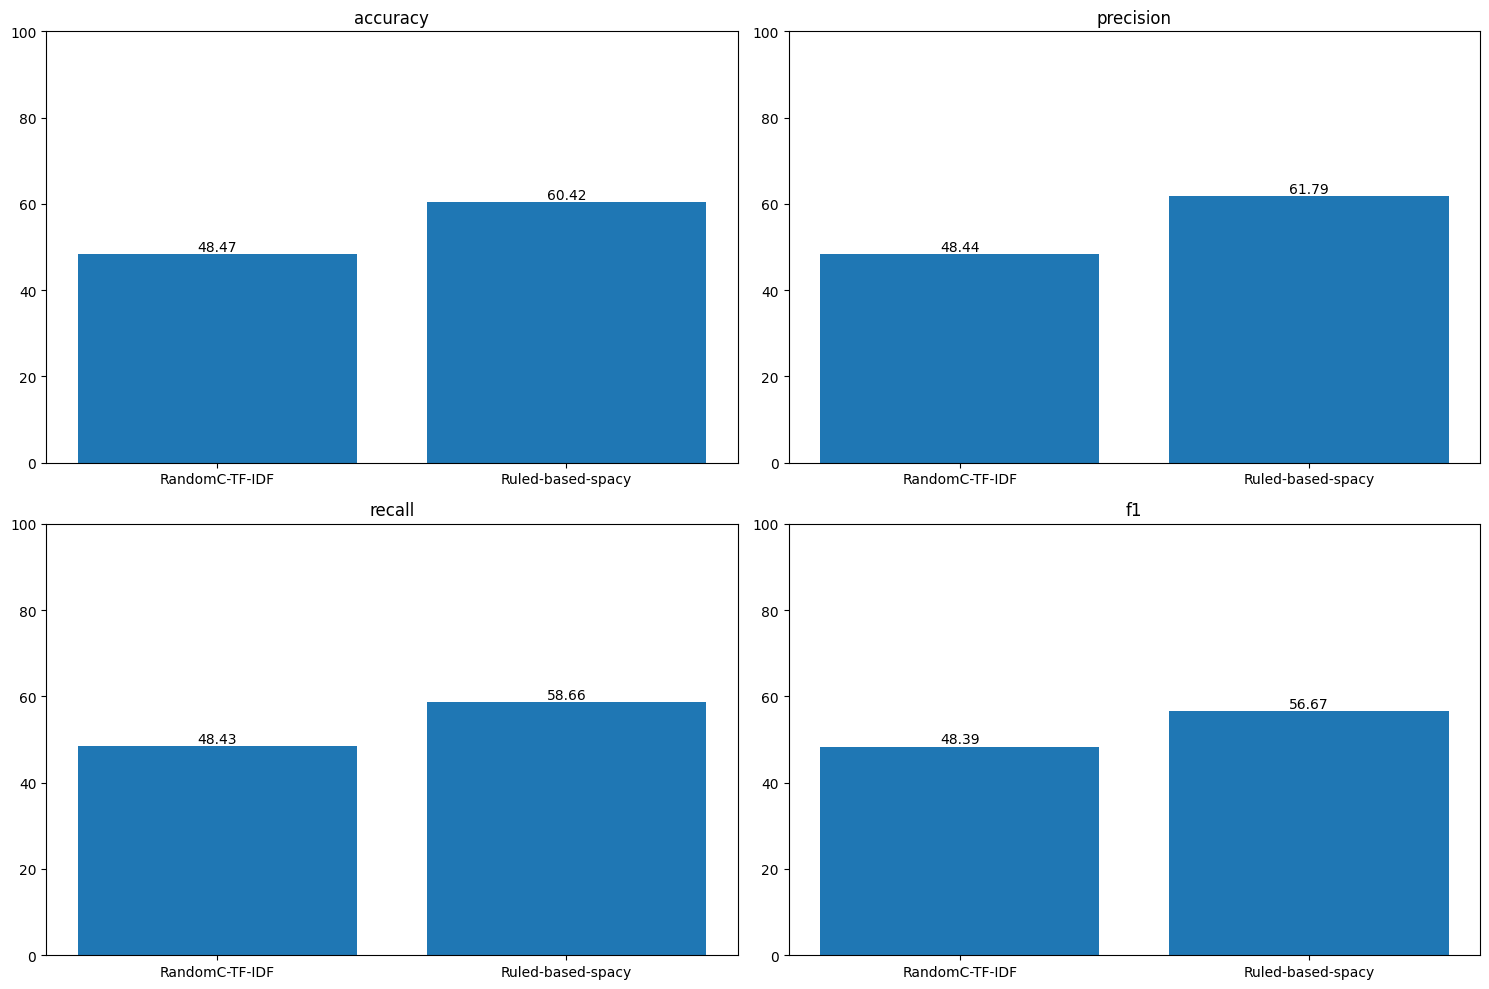

In [39]:
## Comparing with real

metrics_val.run(test_labels, va_df['proba'], "Ruled-based-spacy")
metrics_val.plot()

### Error Analysis

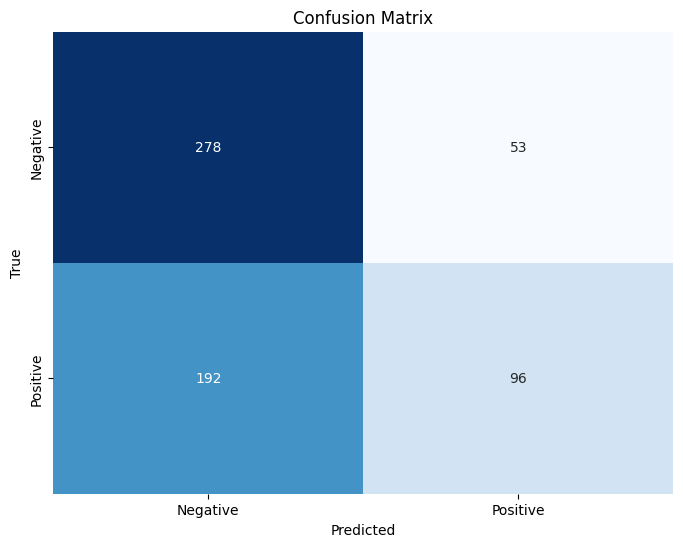

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, va_df['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
df_val2 = df_test.copy()

#Create an index column to join with our prediction results
df_val2 = df_val2.reset_index()

## Merge with new data
merged_data = df_val2.merge(va_df[['index','proba']],how='left',left_on='index',right_on='index',suffixes=['_tr','_df'])
merged_data.head()

,index,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,proba
0,0,AP World History exam today; feel great 'bout ...,1,10,ap world history exam today ; feel great ' bou...,,,ap world history exam today ; feel great ' bou...,1
1,1,@StDAY So apparently the Boston Globe could cl...,0,22,so apparently the boston globe could close . r...,,,so apparently the boston globe could close . r...,0
2,2,Check out http://www.wordcade.com/ for FREE fl...,1,7,check out for free flash games .,,,check out for free flash games .,0
3,3,@lein_ Leiiin I can play the introoo,1,7,lein i can play the intro,,,lein i can play the intro,0
4,4,Out to dinner with Jason to celebrate our fift...,1,10,out to dinner with jason to celebrate our fift...,,,out to dinner with jason to celebrate our fift...,0


In [42]:
## Printing False Negatives
print('MISSCLASSIFIED TWEETS EXPLORATION')
for i in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text'][0:25]:
    print(i)

MISSCLASSIFIED TWEETS EXPLORATION
check out for free flash games .
lein i can play the intro
out to dinner with jason to celebrate our fifth anniversary
do not worry , i wasn ' t tucked away on my little one ' s bookshelf either .
chillin on a rainy saturday afternoon
they can win , but it ' ll be by points . and bod will make the difference . think drop goal in irl eng game , plus his try
my pleasure !
just got home from " hit the streets " - bayside church making a massive difference in the community . hanging out for church tonight
no doubt my dear ! are you around tomorrow ? how be you ?
i really need to clean my room . come do it for me and ill shoot u
having visions of you sitting in sb pouring some out for your homies . i hope you did not ! what a waste that would be
sweet dreams everyone ! i am utterly exhausted ! nite nite !
at the house chillin
ouch . i went from having dollars to . stupid flights . this trip better be worth it ! beach tomorrow
freut mich
doubt it
reopening o

#### How can we reduce the amount of false negatives?

Twitter data presents certain challenges:

- Frequently, we encounter questions that lack clear sentiment expression.
- Sometimes, the count of positive and negative instances is equal, leading to classification as negatives based on our threshold.
- Given the intricate variety of positive patterns, we won't be able to cover all possibilities, therefore increasing the number of false negatives.
- Positive and negative sarcasm further complicates accurate classification, as seen in examples like: "I live in a basement. That's why I am so mysterious."


Proposal to reduce False negatives  

To address the issue of false negatives, we suggest a strategy suited to the complexity of tweets, characterized by informal language. Our plan involves conducting regular error analyses and augmenting our matcher patterns with new positive patterns. This iterative approach aims to develop a robust classifier capable of capturing all positive patterns accurately over time. However, we must also devise methods to handle neutral tweets and positive/negative sarcasm.

- Our initial step entails identifying missing positive patterns within misclassified tweets and incorporating them into our matcher.





276


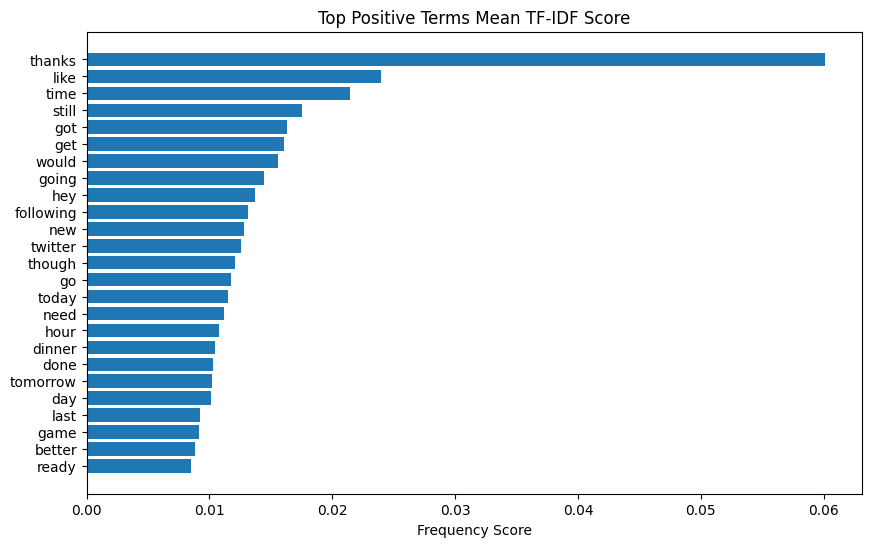

In [43]:
## Plot TFIDF identify missing positive patterns
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)],1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

In [44]:
#Identifying positive patterns:
positives2 = ['thanks','new','like','thank','well']

print(positives2)

['thanks', 'new', 'like', 'thank', 'well']


In [45]:
## Adding new patterns to matcher
# based on word cloud
positive_patterns2 = [
    [{'LOWER': 'thanks'}],
    [{'LOWER': 'new'}],
    [{'LOWER': 'like'}],
    [{'LOWER': 'thank'}],
    [{'LOWER': 'well'}]
]

## Adding patterns to matcher
matcher.add('positives',positive_patterns2)

In [46]:
#Matching elements in documents
## Matching VALIDATION
docs_v2 = [nlp(doc) for doc in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text']]
matches_v2 = [matcher(d) for d in docs_v2]

In [47]:
va_df2 = matching_func(docs_v2,matches_v2)
va_df2

,index,total,positive,negative,pos_words,neg_words
0,0,0,0,0,NaN,NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
187,187,0,0,0,NaN,NaN
188,188,0,0,0,NaN,NaN
189,189,0,0,0,NaN,NaN
190,190,0,0,0,NaN,NaN


In [48]:
va_df2['proba'] = np.where(va_df2['total'] != 0, (va_df2['positive'] / va_df2['total']) > threshold, 0)
va_df2

,index,total,positive,negative,pos_words,neg_words,proba
0,0,0,0,0,NaN,NaN,0
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
187,187,0,0,0,NaN,NaN,0
188,188,0,0,0,NaN,NaN,0
189,189,0,0,0,NaN,NaN,0
190,190,0,0,0,NaN,NaN,0


In [49]:
## Checking That lens for both results match
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']) == len(va_df2['proba']))
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']))
print(len(va_df2['proba']))


True
192
192


In [50]:
#check if missing values
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba'].isna().mean())
print(va_df2['proba'].isna().mean())


0.0
0.0


In [51]:
# Different indexes
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index)
print(va_df2.index)

Int64Index([  2,   3,   4,   7,   9,  10,  12,  14,  15,  16,
            ...
            574, 581, 582, 588, 591, 598, 599, 612, 615, 616],
           dtype='int64', length=192)
RangeIndex(start=0, stop=192, step=1)


In [52]:
# Make copies of the dataframes
merged_data_copy = merged_data.copy()
va_df2_copy = va_df2.copy()

# Find the subset indices in the copied dataframe


df_merge = pd.DataFrame({'index':merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index,
                         'proba1':(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']).tolist(),
                         'proba2':va_df2['proba'].tolist()
                         })

df_merge['proba3'] = np.where(df_merge['proba1'] != df_merge['proba2'], df_merge['proba2'], df_merge['proba1'])
df_merge.set_index('index', inplace=True)
df_merge


,proba1,proba2,proba3
index,,,
2,0,0,0
3,0,0,0
4,0,0,0
7,0,0,0
9,0,0,0
...,...,...,...
598,0,0,0
599,0,0,0
612,0,0,0


In [53]:
#Now that we made sure that indexes will match, replace in merged data:
for index, value in zip(merged_data_copy[(merged_data_copy['label'] == 1) & (merged_data_copy['proba'] == 0)].index, df_merge['proba3']):
    merged_data_copy.loc[index, 'proba'] = value

---

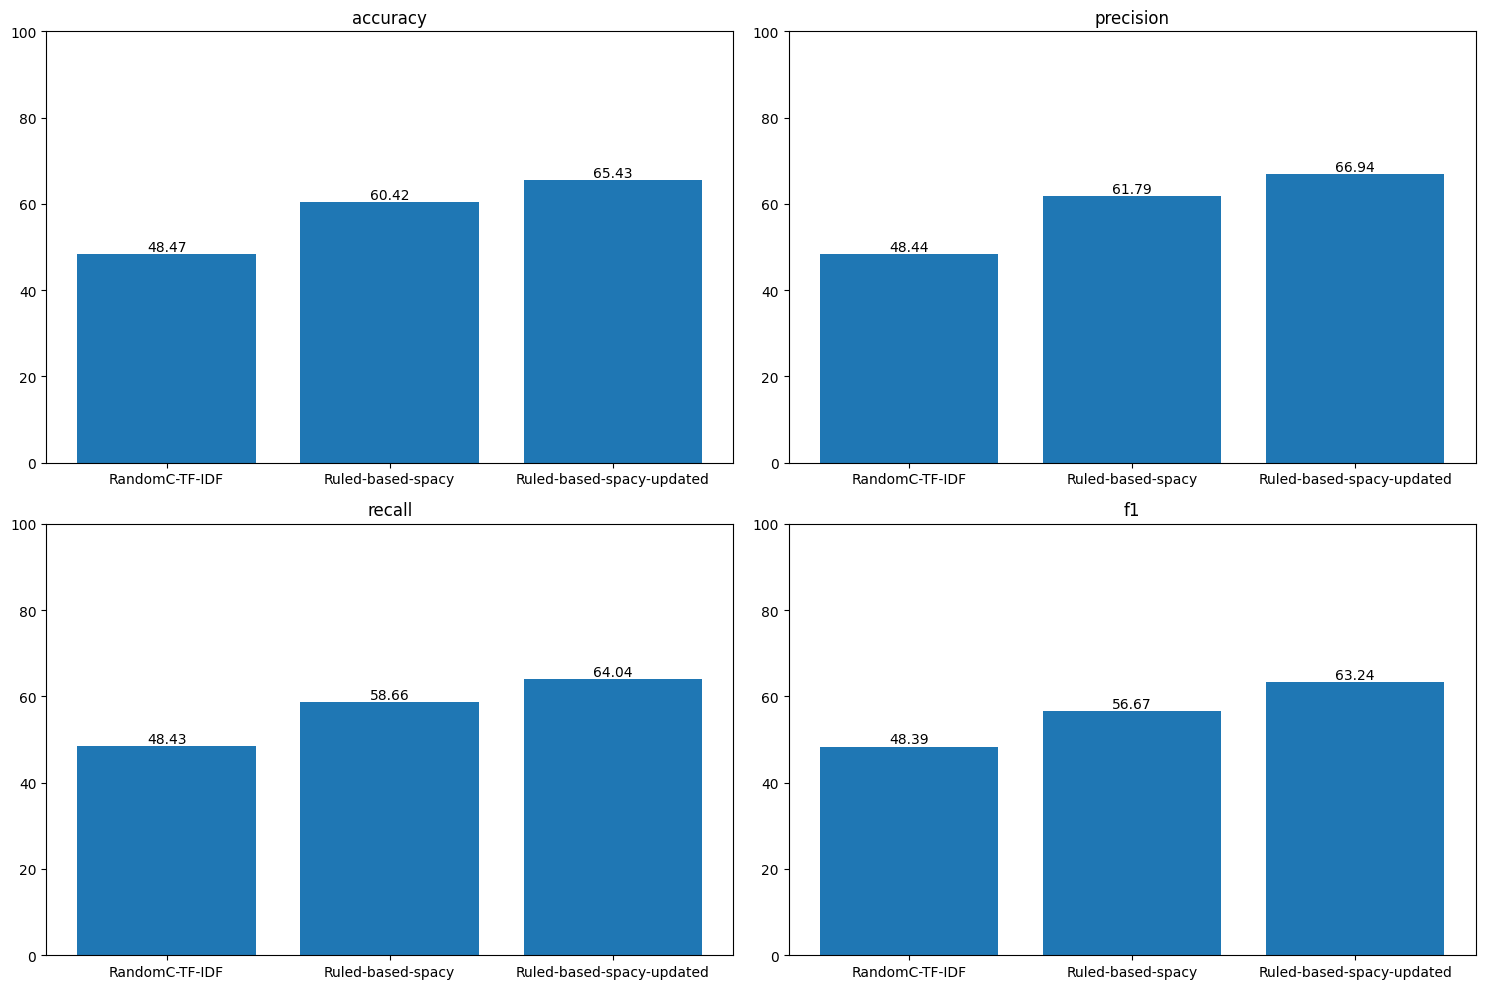

In [54]:
metrics_val.run(test_labels, merged_data_copy['proba'], "Ruled-based-spacy-updated")
metrics_val.plot()

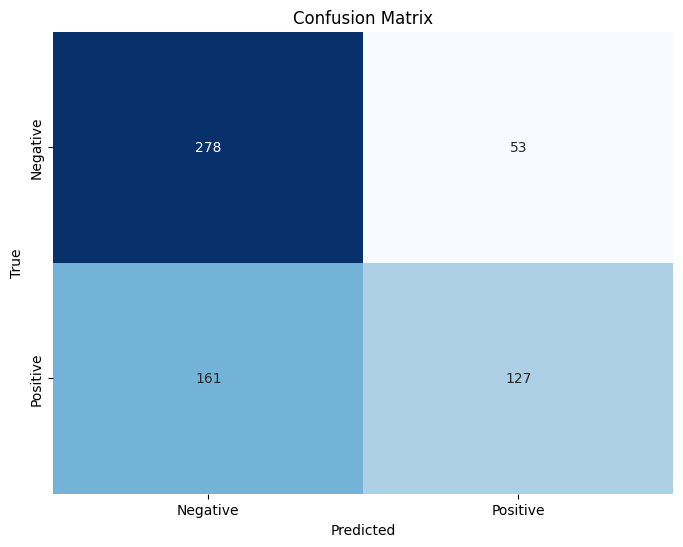

In [55]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels,  merged_data_copy['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
## Reduction of False Negatives
((17495 / 20656) -1) * 100

-15.303059643687067

#### We managed to reduce the number of false negatives by 15% after incorporating the new batch of positive patterns learned from the error analysis

### Rule-Based Benchmark with Vader

In [59]:
# Initialize the SentimentIntensityAnalyzer.
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']

# Calculate compound score and get tweet length
df_test['sentiment'] = df_test['clean_text'].apply(function)
df_test['clean_length'] = [len(i.split()) for i in df_test['clean_text']]

test = df_test[['clean_text','clean_length','sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [60]:
#Adding Sentiment Label
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

df_test['sentiment_label'] = df_test['sentiment'].apply(getAnalysis)

#Scaling score to the length of the review
df_test.head(5)

,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,sentiment,clean_length,sentiment_label
0,AP World History exam today; feel great 'bout ...,1,10,ap world history exam today ; feel great ' bou...,,,ap world history exam today ; feel great ' bou...,0.6588,13,Positive
1,@StDAY So apparently the Boston Globe could cl...,0,22,so apparently the boston globe could close . r...,,,so apparently the boston globe could close . r...,0.0000,23,Neutral
2,Check out http://www.wordcade.com/ for FREE fl...,1,7,check out for free flash games .,,,check out for free flash games .,0.5106,7,Positive
3,@lein_ Leiiin I can play the introoo,1,7,lein i can play the intro,,,lein i can play the intro,0.3400,6,Positive
4,Out to dinner with Jason to celebrate our fift...,1,10,out to dinner with jason to celebrate our fift...,,,out to dinner with jason to celebrate our fift...,0.5719,10,Positive


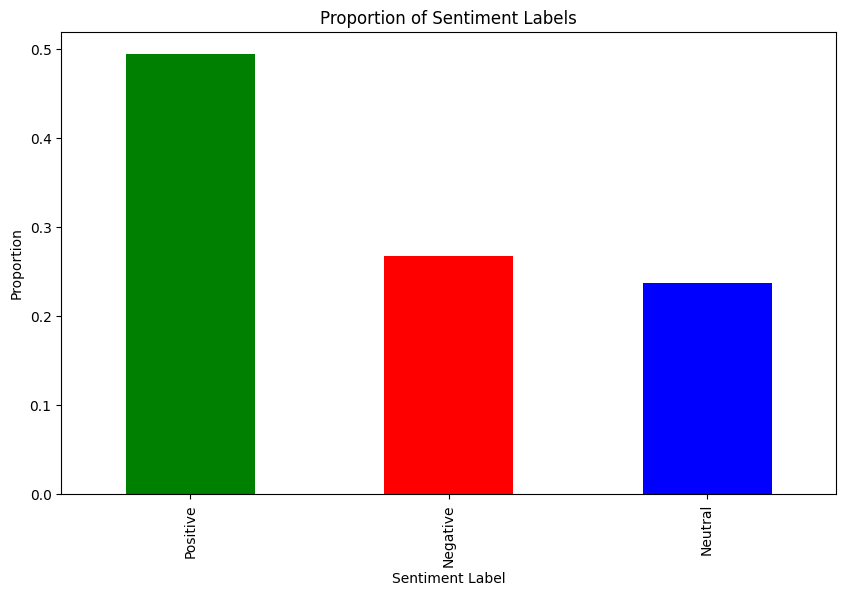

In [61]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()


## Looking at WordCloud for inspection of Neutral Words

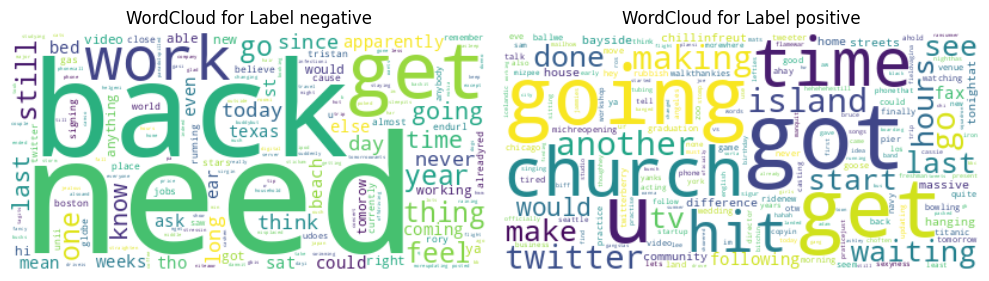

In [62]:
## Looking at a WordCloud to inspect the words in neutral
labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_test[df_test['sentiment_label']=='Neutral']['clean_text'], df_test[df_test['sentiment_label']=='Neutral']['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Classifying Neutral tweets

In [63]:
#Clasifying neutral
# Iterate over rows of DataFrame where 'sentiment_label' is 'Neutral'
for index, row in df_test[df_test['sentiment_label'] == 'Neutral'].iterrows():
    # Analyze sentiment of the text
    score = vader.polarity_scores(row['clean_text'])
    if score['compound'] == 0:  # Positive sentiment
        df_test.at[index, 'sentiment_label'] = 'Negative' ##Any tweet that has no good emotion will be treated as negative
    else:  # Neutral sentiment
        df_test.at[index, 'sentiment_label'] = 'Positive'


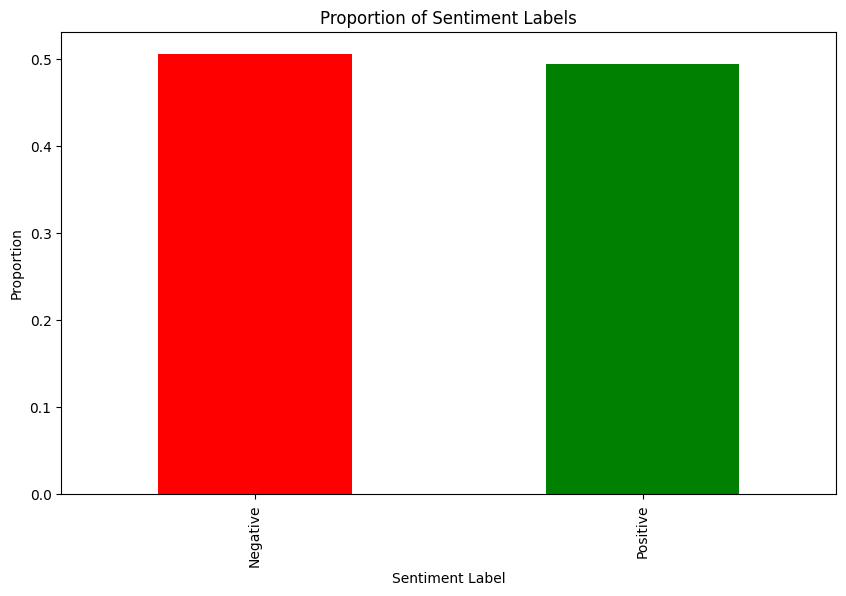

In [64]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()

### Rule-Based Model Performance

In [65]:
#Convert to binary
df_test['sentiment_label'] = [1 if x == 'Positive' else 0 for x in df_test['sentiment_label']]
y_pred = df_test['sentiment_label']
original_labels = df_test['label']

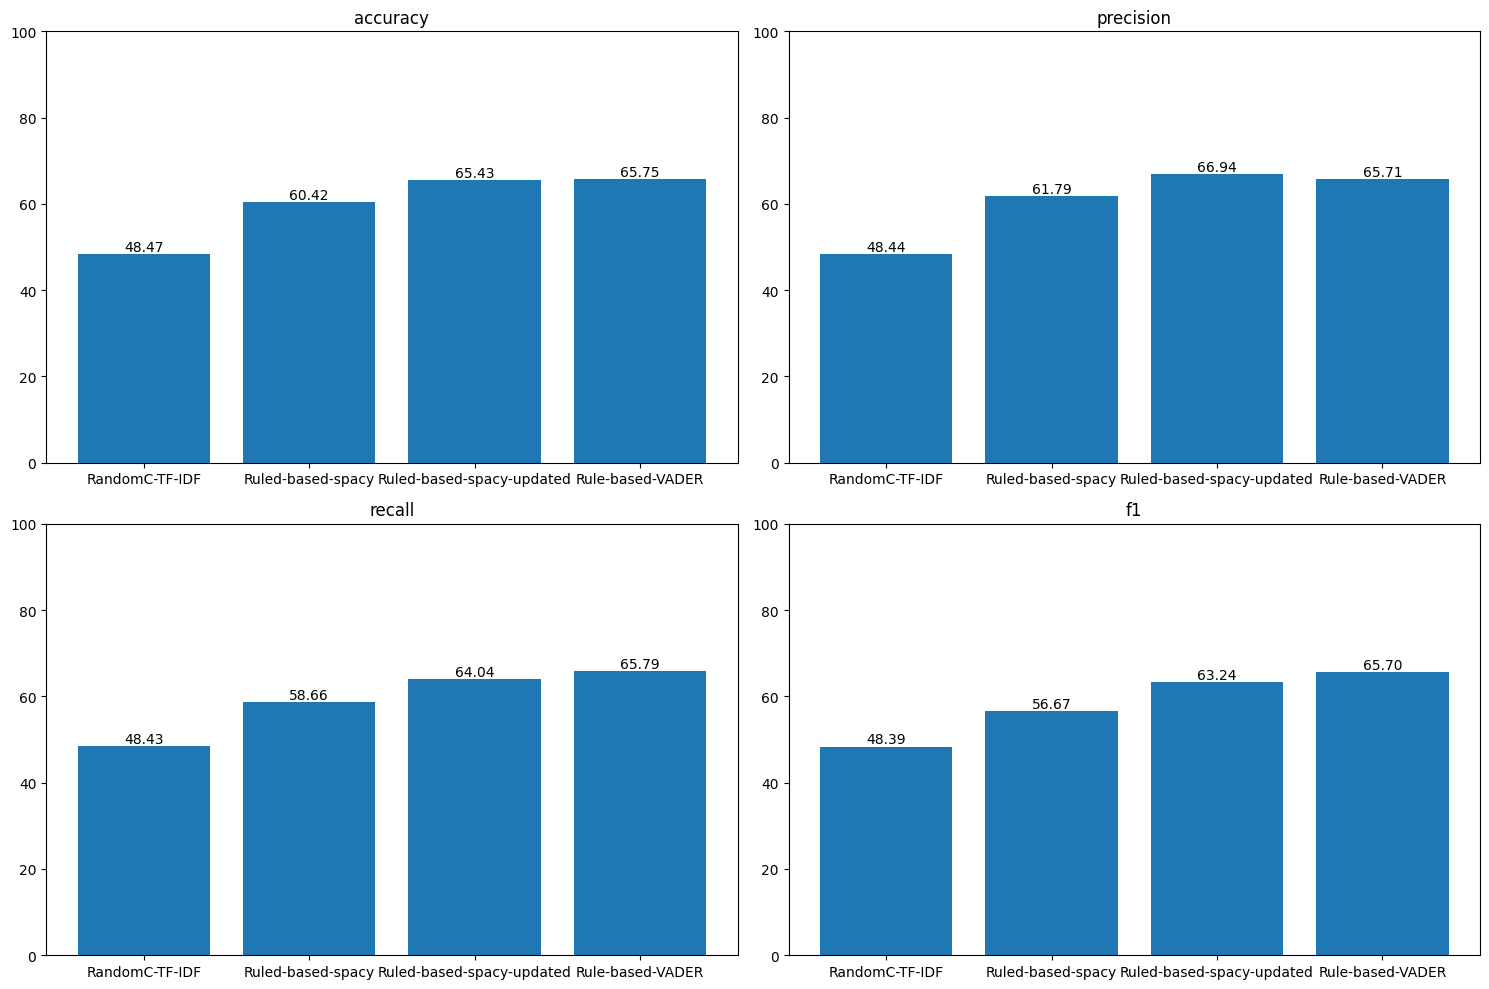

In [66]:
## Model Performance
metrics_val.run(original_labels, y_pred, "Rule-based-VADER")
metrics_val.plot()

---

# Part 2: Data Scientist Challenge
## a. BERT Model with Limited Data

In the following exercises we will work with clean text.

In [67]:
train_data_clean = df_train['clean_text']
validation_data_clean = df_val['clean_text']
test_data_clean = df_test['clean_text']

In [68]:
# Set the seed for reproducibility
np.random.seed(42)

# First, we'll select 32 random rows from the DataFrame using the sample method.
df_train_32 = df_train.sample(n=32)

In [69]:
train_data_32 = df_train_32['clean_text']
train_labels_32 = df_train_32['label']

### BERT SETUP

In [70]:
checkpoint="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32 # impossible to have bigger batch as far as we have just 32 observations in the train
max_length=40 # fine for the length of the sentences in our dataset - changed it according to the distribution
rate = 0.5 # dropout parameters - tried different options, 0.5 still performs better
num_labels = len(np.unique(validation_labels))

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [71]:
## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer
final_embedding_layer = embedding_layer[0] #last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]
# First dimension is the number of rows
# Second dimension is the number of tokens (in our case 64)
# The last dimension is the embedding size, in this case 768

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [72]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [73]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_32).reshape(-1, 1)).toarray()

In [74]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(train_data_32)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/7


Epoch: 100%|██████████| 1/1 [00:33<00:00, 33.31s/it]

1/1 [==============================] - 53s 53s/step - loss: 1.0170 - recall: 0.6250 - precision: 0.6250
Epoch 2/7


Epoch: 3it [00:52, 15.87s/it]                       

1/1 [==============================] - 0s 348ms/step - loss: 0.6898 - recall: 0.6250 - precision: 0.6250
Epoch 3/7


Epoch: 4it [00:53, 10.50s/it]

1/1 [==============================] - 0s 256ms/step - loss: 0.6749 - recall: 0.7188 - precision: 0.7188
Epoch 4/7


Epoch: 5it [00:53,  7.12s/it]

1/1 [==============================] - 0s 253ms/step - loss: 0.6842 - recall: 0.7188 - precision: 0.7188
Epoch 5/7


Epoch: 6it [00:53,  4.92s/it]

1/1 [==============================] - 0s 254ms/step - loss: 0.3238 - recall: 0.8750 - precision: 0.8750
Epoch 6/7


Epoch: 7it [00:53,  3.45s/it]

1/1 [==============================] - 0s 268ms/step - loss: 0.2686 - recall: 0.8438 - precision: 0.8438
Epoch 7/7


Epoch: 8it [00:54,  2.47s/it]

1/1 [==============================] - 0s 274ms/step - loss: 0.3611 - recall: 0.8438 - precision: 0.8438


In [75]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


20/20 [==============================] - 5s 91ms/step


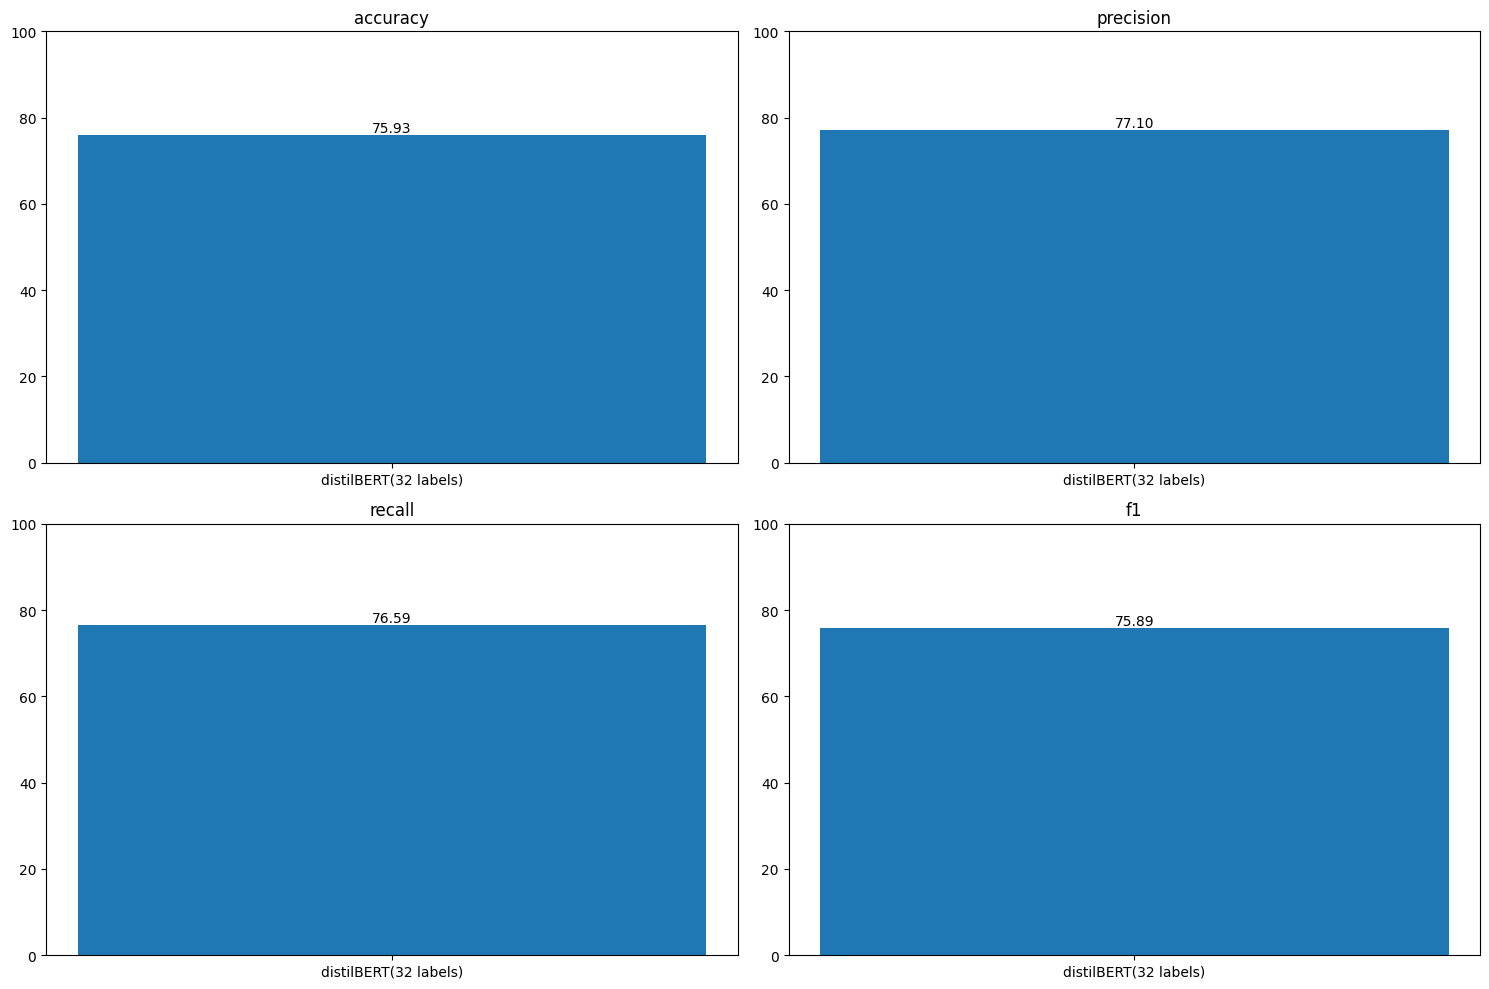

In [77]:
# get the final metrics
metrics_val= Metrics()
metrics_val.run(test_labels, valid_preds, "distilBERT(32 labels)")
metrics_val.plot()
tf.keras.backend.clear_session()

As we see, BERT trained on 32 labels performs slightly better than random. Note that metrics vary in the range [0.52, 0.62], depending on the run, as all batches are randomly assigned.

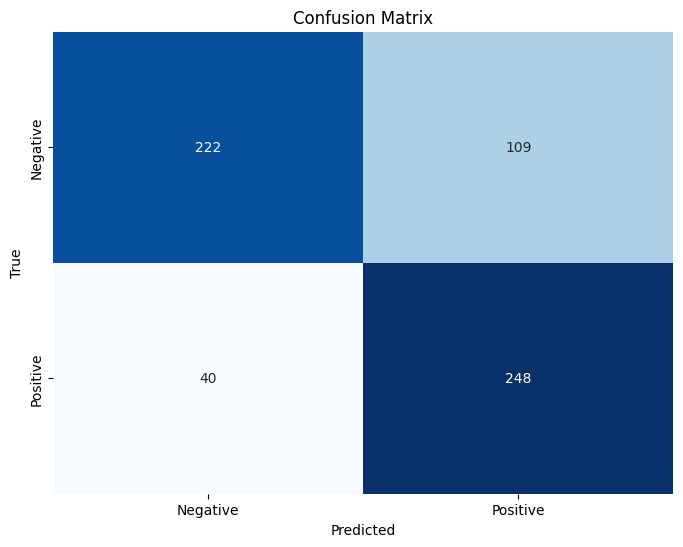

In [78]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## b. Dataset Augmentation

Text data augmentation approaches include:

+ Synonym Replacement: Replace words with their synonyms.
+ Random Insertion: Insert random words into the text.
+ Random Deletion: Randomly delete words from the text.
+ Random Swap: Swap two words randomly in the text.
+ Text Masking: Replace words or phrases with a mask token.

As far as we have very small dataset (DTM is of shape 32:305) I chose not to work with deletion or masking, but rather with synonyms. I thought of two approaches to do so:

### Data Augmentation: Manually Gathered Synonyms

First approach was to analyse the most common words associated with positive and negative sentiments and manually create a dictionary with synonyms. Then, I augmented data with 50 (tried more, but performance was worse, probably bacause of the limited variety of the changes and the fact, that probably misclassified observations could be misclassified now twice) observations and trained the same BERT with augmented data.

In [ ]:
# I had slightly different approach, but changed it to Mikel's so to have the same logic throughout the notebook. Will have to move this and next cell to the first exercise later on.
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train_32['clean_text'])

433


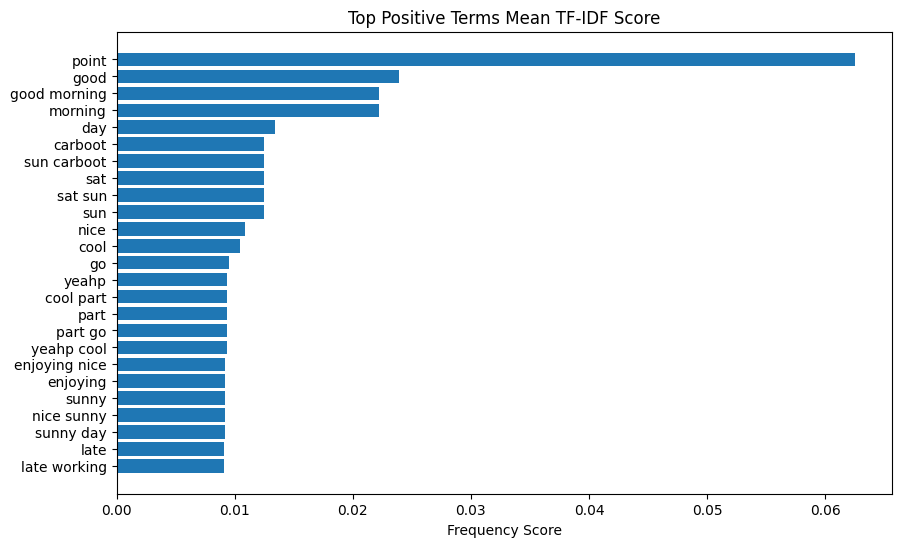

In [80]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

433


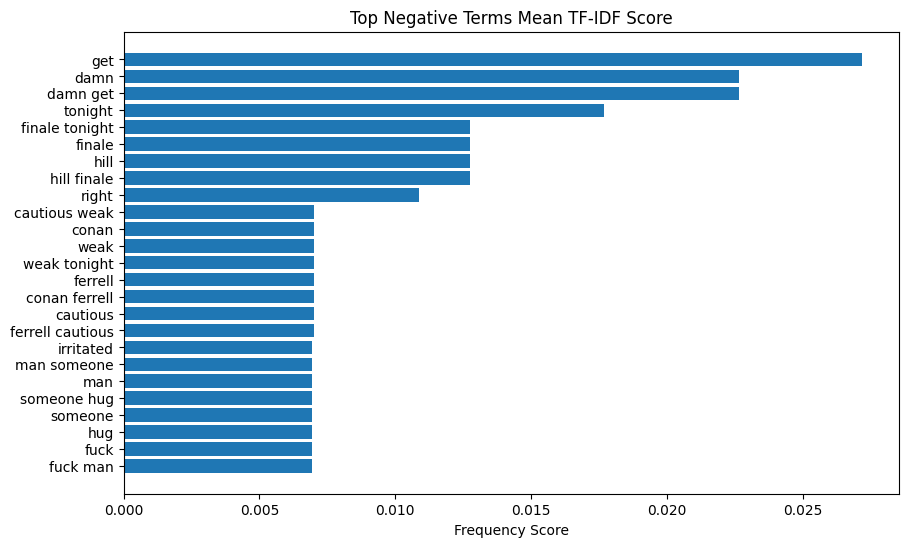

In [81]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

I got top 'most positive' and 'most negative' terms, manually chose some of them and assigned synonyms.

In [82]:
# Sort the dataframe by the 'score' column in decreasing order
neg_tf_idf_sorted = neg_tf_idf.sort_values(by='score', ascending=False)
pos_tf_idf_sorted = pos_tf_idf.sort_values(by='score', ascending=False)

# Extract the top 25 terms from the sorted dataframe
top_terms_neg = neg_tf_idf_sorted['terms'].head(25).tolist()
top_terms_pos = pos_tf_idf_sorted['terms'].head(25).tolist()

# Print the list of top 25 terms
print(top_terms_neg)
print(top_terms_pos)

['get', 'damn', 'damn get', 'tonight', 'finale tonight', 'finale', 'hill', 'hill finale', 'right', 'cautious weak', 'conan', 'weak', 'weak tonight', 'ferrell', 'conan ferrell', 'cautious', 'ferrell cautious', 'irritated', 'man someone', 'man', 'someone hug', 'someone', 'hug', 'fuck', 'fuck man']
['point', 'good', 'good morning', 'morning', 'day', 'carboot', 'sun carboot', 'sat', 'sat sun', 'sun', 'nice', 'cool', 'go', 'yeahp', 'cool part', 'part', 'part go', 'yeahp cool', 'enjoying nice', 'enjoying', 'sunny', 'nice sunny', 'sunny day', 'late', 'late working']


In [83]:
synonyms = {
    'wrong': ['incorrect', 'faulty', 'mistaken'],
    'love': ['adore', 'cherish', 'admire'],
    'time': ['moment', 'occasion', 'period'],
    'wtf': ['what the heck', 'what on earth', 'what in the world'],
    'whats': ['what is', 'what does', 'what has'],
    'think': ['consider', 'contemplate', 'believe'],
    'favorite': ['preferred', 'beloved', 'favored'],
    'sanam': ['dear', 'beloved', 'darling'],
    'life': ['existence', 'living', 'lifetime'],
    'good': ['great', 'excellent', 'fine'],
    'work': ['job', 'employment', 'occupation'],
    'good hear': ['nice to hear', 'pleasing to hear', 'great to hear'],
    'enjoy': ['appreciate', 'have fun', 'relish'],
    'day': ['daylight', 'sunlight', 'daytime'],
    'lovin': ['affection', 'love', 'romance'],
    'fantastic': ['amazing', 'incredible', 'marvelous'],
    'remember': ['recall', 'recollect', 'bring to mind'],
    'glad': ['happy', 'pleased', 'delighted'],
    'shout': ['yell', 'scream', 'holler'],
    'eco': ['environmentally friendly', 'green', 'sustainable'],
    'enjoyed': ['appreciated', 'liked', 'delighted in'],
}

In [84]:
# Function to replace key word with a random synonym
def replace_with_synonym(text, synonyms_dict):
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms_dict:
            synonyms = synonyms_dict[word]
            # Randomly select a synonym
            new_word = random.choice(synonyms)
            # Replace the key word with the selected synonym
            words[i] = new_word
    return ' '.join(words)

# Initialize an empty DataFrame to store new observations
new_rows = pd.DataFrame(columns=df_train_32.columns)

# Generate additional 50 rows
while len(new_rows) < 50:
    # Identify rows with words from synonyms dictionary
    relevant_rows = df_train_32[df_train_32['clean_text'].apply(lambda x: any(word in synonyms for word in x.split()))]
    # Duplicate each relevant row and replace key word with synonym
    for idx, row in relevant_rows.iterrows():
        new_row = row.copy()
        new_row['clean_text'] = replace_with_synonym(row['clean_text'], synonyms)
        new_rows = new_rows.append(new_row, ignore_index=True)
        if len(new_rows) >= 50:
            break

# Display the new DataFrame with 50 new rows
print(new_rows)

                                                 text label text_length  \
0   says using Google Calendar to organize my day ...     1           9   
1   Unfortunatly Andy didn't win the in the mix DJ...     0          23   
2           @mOFrIz I'm trying real hard to feel good     1           8   
3   http://twitpic.com/6ry1t - Enjoying a nice sun...     1           9   
4                          @ebassman and good morning     1           4   
5   @kkaleal I know -- but the packers also mucked...     0          25   
6   says using Google Calendar to organize my day ...     1           9   
7   Unfortunatly Andy didn't win the in the mix DJ...     0          23   
8           @mOFrIz I'm trying real hard to feel good     1           8   
9   http://twitpic.com/6ry1t - Enjoying a nice sun...     1           9   
10                         @ebassman and good morning     1           4   
11  @kkaleal I know -- but the packers also mucked...     0          25   
12  says using Google Cal

<ipython-input-84-5dc4f9f0cb87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


In [85]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame shape
print(augmented_df.shape)

(82, 7)


In [86]:
# Define data and labels
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

Note, that we will work with the same BERT model, so I will not change anything in the model architecture.

In [87]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [88]:
X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

from keras.callbacks import EarlyStopping
bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# # Now, pass the wrapped generator to fit
history = bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/7



Epoch:  50%|█████     | 1/2 [00:52<00:52, 52.01s/it]

1/2 [==============>...............] - ETA: 1:13 - loss: 0.0465 - recall: 1.0000 - precision: 1.0000


Epoch: 3it [01:13, 21.34s/it]                       

2/2 [==============================] - 74s 619ms/step - loss: 0.0888 - recall: 0.9688 - precision: 0.9688
Epoch 2/7



Epoch: 4it [01:13, 14.17s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0196 - recall: 1.0000 - precision: 1.0000


Epoch: 5it [01:14,  9.63s/it]

2/2 [==============================] - 1s 387ms/step - loss: 0.0247 - recall: 1.0000 - precision: 1.0000
Epoch 3/7



Epoch: 6it [01:14,  6.67s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0145 - recall: 1.0000 - precision: 1.0000


Epoch: 7it [01:15,  4.68s/it]

2/2 [==============================] - 1s 327ms/step - loss: 0.0328 - recall: 0.9800 - precision: 0.9800
Epoch 4/7



Epoch: 8it [01:15,  3.33s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - recall: 1.0000 - precision: 1.0000


Epoch: 9it [01:15,  2.42s/it]

2/2 [==============================] - 1s 365ms/step - loss: 0.0160 - recall: 1.0000 - precision: 1.0000
Epoch 5/7



Epoch: 10it [01:16,  1.80s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - recall: 1.0000 - precision: 1.0000


Epoch: 11it [01:16,  1.31s/it]

2/2 [==============================] - 1s 398ms/step - loss: 0.0027 - recall: 1.0000 - precision: 1.0000
Epoch 6/7



Epoch: 12it [01:16,  1.04s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0175 - recall: 1.0000 - precision: 1.0000


Epoch: 13it [01:17,  1.20it/s]

2/2 [==============================] - 1s 223ms/step - loss: 0.0306 - recall: 0.9800 - precision: 0.9800
Epoch 7/7



Epoch: 14it [01:17,  1.54it/s]

1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - recall: 1.0000 - precision: 1.0000


Epoch: 15it [01:17,  1.77it/s]

2/2 [==============================] - 1s 381ms/step - loss: 0.0016 - recall: 1.0000 - precision: 1.0000


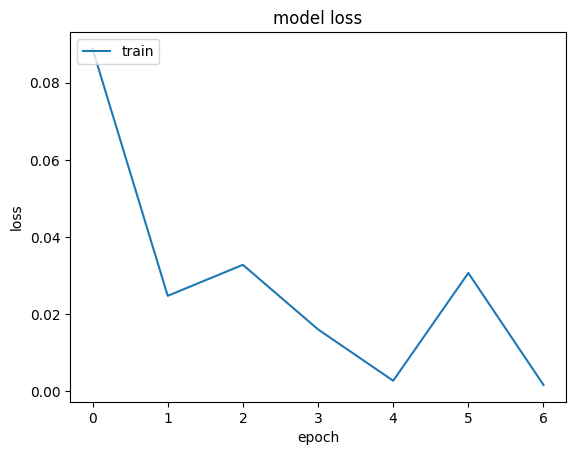

In [89]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 7s 101ms/step


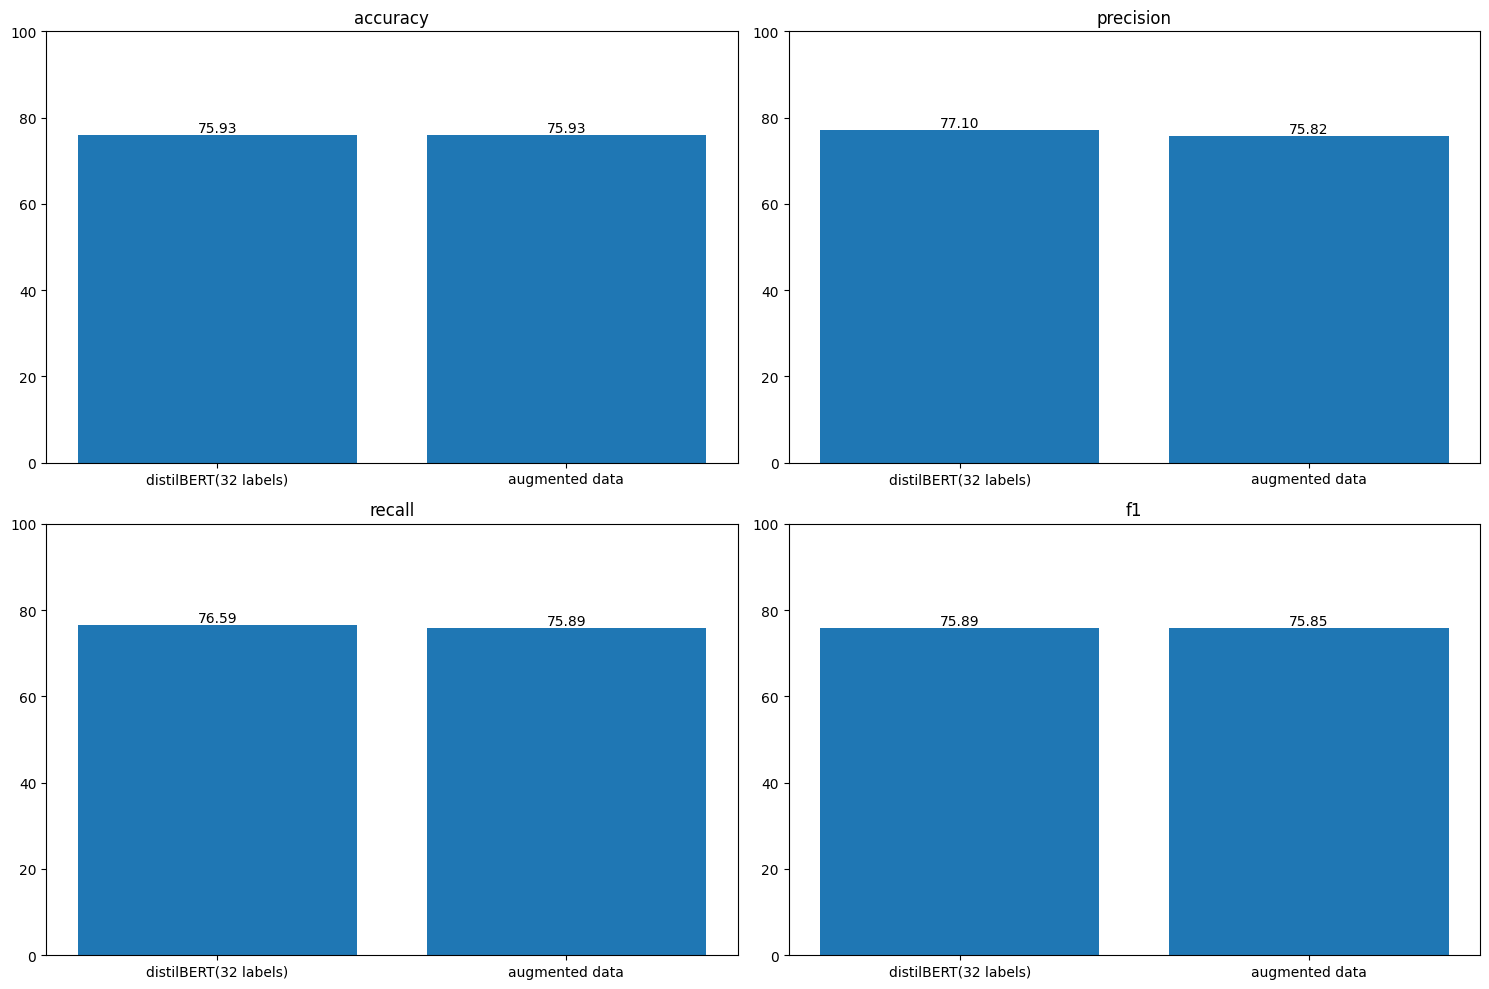

In [91]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data")
metrics_val.plot()
tf.keras.backend.clear_session()

### Data Augmentation: Synonyms from WordNet

I didn't choose to work with WordNet packages in the beginning, as far as synonyms look kind of random and don't usually properly reflect the meaning of the word (probably because of multiple meanings) and don't consider the context. But as far as I couldn't manually assign synonyms to all (or at least many) tokens, I decided to try WordNet as well.

So the second approach is to rendomly change 30% of the tokens in the comments (I tried different shares, 30% performed better) and add 32*20 (tried different numbers as well) new rows.

In [92]:
# Function to get synonyms from WordNet
def get_wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to replace random words with WordNet synonyms
def replace_with_synonym_wordnet(text):
    words = text.split()
    for i, word in enumerate(words):
        # Randomly decide whether to replace the word with a synonym
        if random.random() < 0.3:  # Adjust the probability as needed
            # Get WordNet synonyms for the word
            synonyms = get_wordnet_synonyms(word)
            if synonyms:
                # Randomly select a synonym
                new_word = random.choice(synonyms)
                # Replace the word with the selected synonym
                words[i] = new_word
    return ' '.join(words)

# Duplicate each row and replace random words with WordNet synonyms
new_rows = pd.DataFrame(columns=df_train_32.columns)
for idx, row in df_train_32.iterrows():
    for _ in range(20):  # Duplicate 20 times - can be adjusted as needed
        # Duplicate the row
        new_row = row.copy()
        # Replace random words in the 'clean_text' column with WordNet synonyms
        new_row['clean_text'] = replace_with_synonym_wordnet(row['clean_text'])
        # Append the new row to the DataFrame
        new_rows = new_rows.append(new_row, ignore_index=True)

# Display the new DataFrame with duplicated rows and random word replacements
print(new_rows.head())


<ipython-input-92-a44f8c0859a0>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


                                                text label text_length  \
0  says using Google Calendar to organize my day ...     1           9   
1  says using Google Calendar to organize my day ...     1           9   
2  says using Google Calendar to organize my day ...     1           9   
3  says using Google Calendar to organize my day ...     1           9   
4  says using Google Calendar to organize my day ...     1           9   

                                          clean_text clean_emotions hashtag  \
0  says victimisation google calendar to organize...                          
1      says apply google calendar to organize my day                          
2  suppose use google calendar to organize my day...                          
3      says using google calendar to organise my day                          
4  says victimisation google calendar to organize...                          

                                     text_emotion  
0  says using google calenda

From the printed first rows you actually may see (comparing text and clean text, which was duplicated), that synonyms are kind of weird.

In [93]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame
print(augmented_df.shape)

(672, 7)


In [94]:
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

In [95]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [96]:
X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
#bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)

history = bert_model.fit(batches_with_progress, epochs=10, steps_per_epoch=steps_per_epoch)



Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/10




Epoch:   5%|▍         | 1/21 [00:44<14:41, 44.06s/it]

 1/21 [>.............................] - ETA: 19:54 - loss: 0.2604 - recall: 0.9688 - precision: 0.9688



Epoch:  14%|█▍        | 3/21 [00:59<05:10, 17.27s/it]

 2/21 [=>............................] - ETA: 9s - loss: 0.2975 - recall: 0.9375 - precision: 0.9375   



Epoch:  19%|█▉        | 4/21 [01:00<03:14, 11.46s/it]

 3/21 [===>..........................] - ETA: 9s - loss: 0.3491 - recall: 0.9062 - precision: 0.9062



Epoch:  24%|██▍       | 5/21 [01:00<02:05,  7.87s/it]

 4/21 [====>.........................] - ETA: 8s - loss: 0.2641 - recall: 0.9297 - precision: 0.9297



Epoch:  29%|██▊       | 6/21 [01:01<01:22,  5.47s/it]

 5/21 [======>.......................] - ETA: 7s - loss: 0.2331 - recall: 0.9312 - precision: 0.9312



Epoch:  33%|███▎      | 7/21 [01:01<00:54,  3.86s/it]

 6/21 [=======>......................] - ETA: 6s - loss: 0.2262 - recall: 0.9323 - precision: 0.9323



Epoch:  38%|███▊      | 8/21 [01:02<00:36,  2.77s/it]

 7/21 [=========>....................] - ETA: 6s - loss: 0.2155 - recall: 0.9375 - precision: 0.9375



Epoch:  43%|████▎     | 9/21 [01:02<00:24,  2.04s/it]

 8/21 [==========>...................] - ETA: 5s - loss: 0.2117 - recall: 0.9414 - precision: 0.9414



Epoch:  48%|████▊     | 10/21 [01:02<00:17,  1.59s/it]

 9/21 [===========>..................] - ETA: 5s - loss: 0.1998 - recall: 0.9444 - precision: 0.9444



Epoch:  52%|█████▏    | 11/21 [01:03<00:12,  1.23s/it]

10/21 [=============>................] - ETA: 4s - loss: 0.1808 - recall: 0.9500 - precision: 0.9500



Epoch:  57%|█████▋    | 12/21 [01:03<00:08,  1.04it/s]

11/21 [==============>...............] - ETA: 4s - loss: 0.1662 - recall: 0.9545 - precision: 0.9545



Epoch:  62%|██████▏   | 13/21 [01:04<00:06,  1.27it/s]

12/21 [================>.............] - ETA: 3s - loss: 0.1584 - recall: 0.9531 - precision: 0.9531



Epoch:  67%|██████▋   | 14/21 [01:04<00:04,  1.51it/s]

13/21 [=================>............] - ETA: 3s - loss: 0.1507 - recall: 0.9567 - precision: 0.9567



Epoch:  71%|███████▏  | 15/21 [01:04<00:03,  1.75it/s]

14/21 [===================>..........] - ETA: 2s - loss: 0.1482 - recall: 0.9576 - precision: 0.9576



Epoch:  76%|███████▌  | 16/21 [01:05<00:02,  1.97it/s]

15/21 [====================>.........] - ETA: 2s - loss: 0.1403 - recall: 0.9604 - precision: 0.9604



Epoch:  81%|████████  | 17/21 [01:05<00:01,  2.16it/s]

16/21 [=====================>........] - ETA: 2s - loss: 0.1332 - recall: 0.9629 - precision: 0.9629



Epoch:  86%|████████▌ | 18/21 [01:06<00:01,  2.19it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.1258 - recall: 0.9651 - precision: 0.9651



Epoch:  90%|█████████ | 19/21 [01:06<00:00,  2.09it/s]

18/21 [========================>.....] - ETA: 1s - loss: 0.1192 - recall: 0.9670 - precision: 0.9670



Epoch:  95%|█████████▌| 20/21 [01:06<00:00,  2.35it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.1141 - recall: 0.9688 - precision: 0.9688



Epoch: 100%|██████████| 21/21 [01:07<00:00,  2.30it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.1092 - recall: 0.9703 - precision: 0.9703



Epoch: 22it [01:07,  2.22it/s]                        

21/21 [==============================] - 68s 423ms/step - loss: 0.1041 - recall: 0.9717 - precision: 0.9717
Epoch 2/10




Epoch: 23it [01:08,  2.08it/s]

 1/21 [>.............................] - ETA: 6s - loss: 0.0031 - recall: 1.0000 - precision: 1.0000



Epoch: 24it [01:08,  2.29it/s]

 2/21 [=>............................] - ETA: 9s - loss: 0.0050 - recall: 1.0000 - precision: 1.0000



Epoch: 25it [01:09,  2.18it/s]

 3/21 [===>..........................] - ETA: 7s - loss: 0.0102 - recall: 1.0000 - precision: 1.0000



Epoch: 26it [01:09,  2.44it/s]

 4/21 [====>.........................] - ETA: 6s - loss: 0.0079 - recall: 1.0000 - precision: 1.0000



Epoch: 27it [01:09,  2.53it/s]

 5/21 [======>.......................] - ETA: 6s - loss: 0.0064 - recall: 1.0000 - precision: 1.0000



Epoch: 28it [01:10,  2.61it/s]

 6/21 [=======>......................] - ETA: 5s - loss: 0.0056 - recall: 1.0000 - precision: 1.0000



Epoch: 29it [01:10,  2.67it/s]

 7/21 [=========>....................] - ETA: 5s - loss: 0.0068 - recall: 1.0000 - precision: 1.0000



Epoch: 30it [01:10,  2.90it/s]

 8/21 [==========>...................] - ETA: 4s - loss: 0.0089 - recall: 1.0000 - precision: 1.0000



Epoch: 31it [01:11,  3.07it/s]

 9/21 [===========>..................] - ETA: 4s - loss: 0.0080 - recall: 1.0000 - precision: 1.0000



Epoch: 32it [01:11,  2.95it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0072 - recall: 1.0000 - precision: 1.0000



Epoch: 33it [01:11,  2.90it/s]

11/21 [==============>...............] - ETA: 3s - loss: 0.0093 - recall: 0.9972 - precision: 0.9972



Epoch: 34it [01:12,  2.89it/s]

12/21 [================>.............] - ETA: 3s - loss: 0.0129 - recall: 0.9948 - precision: 0.9948



Epoch: 35it [01:12,  2.89it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0138 - recall: 0.9928 - precision: 0.9928



Epoch: 36it [01:12,  3.08it/s]

14/21 [===================>..........] - ETA: 2s - loss: 0.0129 - recall: 0.9933 - precision: 0.9933



Epoch: 37it [01:13,  3.00it/s]

15/21 [====================>.........] - ETA: 2s - loss: 0.0121 - recall: 0.9937 - precision: 0.9937



Epoch: 38it [01:13,  3.08it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0115 - recall: 0.9941 - precision: 0.9941



Epoch: 39it [01:13,  3.17it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0197 - recall: 0.9926 - precision: 0.9926



Epoch: 40it [01:14,  3.27it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0187 - recall: 0.9931 - precision: 0.9931



Epoch: 41it [01:14,  3.37it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0182 - recall: 0.9934 - precision: 0.9934



Epoch: 42it [01:14,  3.46it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0175 - recall: 0.9937 - precision: 0.9937



Epoch: 43it [01:14,  3.49it/s]

21/21 [==============================] - 7s 325ms/step - loss: 0.0166 - recall: 0.9940 - precision: 0.9940
Epoch 3/10




Epoch: 44it [01:15,  3.46it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 45it [01:15,  3.53it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0038 - recall: 1.0000 - precision: 1.0000



Epoch: 46it [01:15,  3.58it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0034 - recall: 1.0000 - precision: 1.0000



Epoch: 47it [01:15,  3.59it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0030 - recall: 1.0000 - precision: 1.0000



Epoch: 48it [01:16,  3.55it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0028 - recall: 1.0000 - precision: 1.0000



Epoch: 49it [01:16,  3.56it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0025 - recall: 1.0000 - precision: 1.0000



Epoch: 50it [01:16,  3.52it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0022 - recall: 1.0000 - precision: 1.0000



Epoch: 51it [01:17,  3.58it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0020 - recall: 1.0000 - precision: 1.0000



Epoch: 52it [01:17,  3.32it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0022 - recall: 1.0000 - precision: 1.0000



Epoch: 53it [01:17,  3.43it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0029 - recall: 1.0000 - precision: 1.0000



Epoch: 54it [01:17,  3.49it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0029 - recall: 1.0000 - precision: 1.0000



Epoch: 55it [01:18,  3.52it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0029 - recall: 1.0000 - precision: 1.0000



Epoch: 56it [01:18,  3.54it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0110 - recall: 0.9952 - precision: 0.9952



Epoch: 57it [01:18,  3.56it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0103 - recall: 0.9955 - precision: 0.9955



Epoch: 58it [01:19,  3.60it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0098 - recall: 0.9958 - precision: 0.9958



Epoch: 59it [01:19,  3.61it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0092 - recall: 0.9961 - precision: 0.9961



Epoch: 60it [01:19,  3.40it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0090 - recall: 0.9963 - precision: 0.9963



Epoch: 61it [01:19,  3.44it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0097 - recall: 0.9965 - precision: 0.9965



Epoch: 62it [01:20,  3.47it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0143 - recall: 0.9951 - precision: 0.9951



Epoch: 63it [01:20,  3.48it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0136 - recall: 0.9953 - precision: 0.9953



Epoch: 64it [01:20,  3.28it/s]

21/21 [==============================] - 6s 292ms/step - loss: 0.0134 - recall: 0.9955 - precision: 0.9955
Epoch 4/10




Epoch: 65it [01:21,  3.09it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0053 - recall: 1.0000 - precision: 1.0000



Epoch: 66it [01:21,  3.18it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0030 - recall: 1.0000 - precision: 1.0000



Epoch: 67it [01:21,  3.32it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0025 - recall: 1.0000 - precision: 1.0000



Epoch: 68it [01:22,  3.41it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0264 - recall: 0.9922 - precision: 0.9922



Epoch: 69it [01:22,  3.47it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0213 - recall: 0.9937 - precision: 0.9937



Epoch: 70it [01:22,  3.49it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0220 - recall: 0.9948 - precision: 0.9948



Epoch: 71it [01:22,  3.53it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0190 - recall: 0.9955 - precision: 0.9955



Epoch: 72it [01:23,  3.57it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0201 - recall: 0.9922 - precision: 0.9922



Epoch: 73it [01:23,  3.56it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0197 - recall: 0.9931 - precision: 0.9931



Epoch: 74it [01:23,  3.58it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0183 - recall: 0.9937 - precision: 0.9937



Epoch: 75it [01:24,  3.60it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0167 - recall: 0.9943 - precision: 0.9943



Epoch: 76it [01:24,  3.62it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0154 - recall: 0.9948 - precision: 0.9948



Epoch: 77it [01:24,  3.60it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0143 - recall: 0.9952 - precision: 0.9952



Epoch: 78it [01:24,  3.59it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0133 - recall: 0.9955 - precision: 0.9955



Epoch: 79it [01:25,  3.56it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0286 - recall: 0.9937 - precision: 0.9937



Epoch: 80it [01:25,  3.56it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0268 - recall: 0.9941 - precision: 0.9941



Epoch: 81it [01:25,  3.54it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0254 - recall: 0.9945 - precision: 0.9945



Epoch: 82it [01:26,  3.59it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0240 - recall: 0.9948 - precision: 0.9948



Epoch: 83it [01:26,  3.56it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0228 - recall: 0.9951 - precision: 0.9951



Epoch: 84it [01:26,  3.57it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0218 - recall: 0.9953 - precision: 0.9953



Epoch: 85it [01:26,  3.58it/s]

21/21 [==============================] - 6s 279ms/step - loss: 0.0208 - recall: 0.9955 - precision: 0.9955
Epoch 5/10




Epoch: 86it [01:27,  3.46it/s]

 1/21 [>.............................] - ETA: 5s - loss: 5.8298e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 87it [01:27,  3.52it/s]

 2/21 [=>............................] - ETA: 5s - loss: 6.5489e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 88it [01:27,  3.51it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 8.0694e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 89it [01:28,  3.50it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0017 - recall: 1.0000 - precision: 1.0000    



Epoch: 90it [01:28,  3.52it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0014 - recall: 1.0000 - precision: 1.0000



Epoch: 91it [01:28,  3.56it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 92it [01:28,  3.52it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0011 - recall: 1.0000 - precision: 1.0000



Epoch: 93it [01:29,  3.48it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0010 - recall: 1.0000 - precision: 1.0000



Epoch: 94it [01:29,  3.54it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 9.4184e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 95it [01:29,  3.52it/s]

10/21 [=============>................] - ETA: 3s - loss: 9.7456e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 96it [01:29,  3.50it/s]

11/21 [==============>...............] - ETA: 2s - loss: 9.4993e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 97it [01:30,  3.48it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0013 - recall: 1.0000 - precision: 1.0000    



Epoch: 98it [01:30,  3.54it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 99it [01:30,  3.56it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 100it [01:31,  3.56it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0042 - recall: 0.9979 - precision: 0.9979



Epoch: 101it [01:31,  3.57it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0040 - recall: 0.9980 - precision: 0.9980



Epoch: 102it [01:31,  3.53it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0038 - recall: 0.9982 - precision: 0.9982



Epoch: 103it [01:31,  3.49it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0036 - recall: 0.9983 - precision: 0.9983



Epoch: 104it [01:32,  3.50it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0037 - recall: 0.9984 - precision: 0.9984



Epoch: 105it [01:32,  3.49it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0035 - recall: 0.9984 - precision: 0.9984



Epoch: 106it [01:32,  3.46it/s]

21/21 [==============================] - 6s 286ms/step - loss: 0.0039 - recall: 0.9985 - precision: 0.9985
Epoch 6/10




Epoch: 107it [01:33,  3.37it/s]

 1/21 [>.............................] - ETA: 5s - loss: 8.2776e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 108it [01:33,  3.42it/s]

 2/21 [=>............................] - ETA: 5s - loss: 8.0328e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 109it [01:33,  3.41it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 7.7271e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 110it [01:34,  3.46it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 7.7003e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 111it [01:34,  3.48it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 6.4661e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 112it [01:34,  3.52it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 5.6706e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 113it [01:34,  3.55it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 5.3054e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 114it [01:35,  3.55it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0147 - recall: 0.9922 - precision: 0.9922    



Epoch: 115it [01:35,  3.57it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0131 - recall: 0.9931 - precision: 0.9931



Epoch: 116it [01:35,  3.58it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0120 - recall: 0.9937 - precision: 0.9937



Epoch: 117it [01:35,  3.59it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0110 - recall: 0.9943 - precision: 0.9943



Epoch: 118it [01:36,  3.57it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0101 - recall: 0.9948 - precision: 0.9948



Epoch: 119it [01:36,  3.55it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0093 - recall: 0.9952 - precision: 0.9952



Epoch: 120it [01:36,  3.53it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0087 - recall: 0.9955 - precision: 0.9955



Epoch: 121it [01:37,  3.55it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0085 - recall: 0.9958 - precision: 0.9958



Epoch: 122it [01:37,  3.50it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0080 - recall: 0.9961 - precision: 0.9961



Epoch: 123it [01:37,  3.54it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0076 - recall: 0.9963 - precision: 0.9963



Epoch: 124it [01:37,  3.53it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0073 - recall: 0.9965 - precision: 0.9965



Epoch: 125it [01:38,  3.54it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0069 - recall: 0.9967 - precision: 0.9967



Epoch: 126it [01:38,  3.54it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0066 - recall: 0.9969 - precision: 0.9969



Epoch: 127it [01:38,  3.52it/s]

21/21 [==============================] - 6s 282ms/step - loss: 0.0088 - recall: 0.9955 - precision: 0.9955
Epoch 7/10




Epoch: 128it [01:39,  3.48it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0141 - recall: 1.0000 - precision: 1.0000



Epoch: 129it [01:39,  3.51it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0074 - recall: 1.0000 - precision: 1.0000



Epoch: 130it [01:39,  3.52it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 0.0050 - recall: 1.0000 - precision: 1.0000



Epoch: 131it [01:39,  3.52it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0039 - recall: 1.0000 - precision: 1.0000



Epoch: 132it [01:40,  3.53it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0033 - recall: 1.0000 - precision: 1.0000



Epoch: 133it [01:40,  3.54it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0028 - recall: 1.0000 - precision: 1.0000



Epoch: 134it [01:40,  3.53it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0025 - recall: 1.0000 - precision: 1.0000



Epoch: 135it [01:41,  3.51it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0025 - recall: 1.0000 - precision: 1.0000



Epoch: 136it [01:41,  3.53it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0022 - recall: 1.0000 - precision: 1.0000



Epoch: 137it [01:41,  3.49it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0020 - recall: 1.0000 - precision: 1.0000



Epoch: 138it [01:41,  3.51it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 139it [01:42,  3.50it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0020 - recall: 1.0000 - precision: 1.0000



Epoch: 140it [01:42,  3.53it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0018 - recall: 1.0000 - precision: 1.0000



Epoch: 141it [01:42,  3.49it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0018 - recall: 1.0000 - precision: 1.0000



Epoch: 142it [01:43,  3.49it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 143it [01:43,  3.50it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0018 - recall: 1.0000 - precision: 1.0000



Epoch: 144it [01:43,  3.50it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0017 - recall: 1.0000 - precision: 1.0000



Epoch: 145it [01:43,  3.46it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0021 - recall: 1.0000 - precision: 1.0000



Epoch: 146it [01:44,  3.25it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0020 - recall: 1.0000 - precision: 1.0000



Epoch: 147it [01:44,  3.13it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 148it [01:45,  3.02it/s]

21/21 [==============================] - 6s 300ms/step - loss: 0.0018 - recall: 1.0000 - precision: 1.0000
Epoch 8/10




Epoch: 149it [01:45,  2.87it/s]

 1/21 [>.............................] - ETA: 5s - loss: 1.3575e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 150it [01:45,  3.03it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0015 - recall: 1.0000 - precision: 1.0000    



Epoch: 151it [01:45,  3.18it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 152it [01:46,  3.27it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 153it [01:46,  3.32it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0011 - recall: 1.0000 - precision: 1.0000



Epoch: 154it [01:46,  3.36it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 9.6364e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 155it [01:47,  3.40it/s]

 7/21 [=========>....................] - ETA: 4s - loss: 8.6374e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 156it [01:47,  3.41it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 7.7031e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 157it [01:47,  3.43it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 6.9529e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 158it [01:47,  3.46it/s]

10/21 [=============>................] - ETA: 3s - loss: 6.4061e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 159it [01:48,  3.43it/s]

11/21 [==============>...............] - ETA: 2s - loss: 6.0962e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 160it [01:48,  3.46it/s]

12/21 [================>.............] - ETA: 2s - loss: 8.5298e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 161it [01:48,  3.46it/s]

13/21 [=================>............] - ETA: 2s - loss: 7.9575e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 162it [01:49,  3.48it/s]

14/21 [===================>..........] - ETA: 2s - loss: 7.6755e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 163it [01:49,  3.47it/s]

15/21 [====================>.........] - ETA: 1s - loss: 7.3001e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 164it [01:49,  3.48it/s]

16/21 [=====================>........] - ETA: 1s - loss: 8.3117e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 165it [01:49,  3.47it/s]

17/21 [=======================>......] - ETA: 1s - loss: 7.9058e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 166it [01:50,  3.49it/s]

18/21 [========================>.....] - ETA: 0s - loss: 7.5557e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 167it [01:50,  3.47it/s]

19/21 [==========================>...] - ETA: 0s - loss: 7.2912e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 168it [01:50,  3.48it/s]

20/21 [===========================>..] - ETA: 0s - loss: 7.0169e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 169it [01:51,  3.47it/s]

21/21 [==============================] - 6s 288ms/step - loss: 6.7238e-04 - recall: 1.0000 - precision: 1.0000
Epoch 9/10




Epoch: 170it [01:51,  3.42it/s]

 1/21 [>.............................] - ETA: 5s - loss: 1.4575e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 171it [01:51,  3.46it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0010 - recall: 1.0000 - precision: 1.0000    



Epoch: 172it [01:52,  3.46it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 8.1399e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 173it [01:52,  3.47it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 6.4654e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 174it [01:52,  3.47it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 5.3320e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 175it [01:52,  3.48it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 4.7772e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 176it [01:53,  3.50it/s]

 7/21 [=========>....................] - ETA: 4s - loss: 4.2626e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 177it [01:53,  3.48it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 3.7772e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 178it [01:53,  3.48it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 3.7788e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 179it [01:54,  3.46it/s]

10/21 [=============>................] - ETA: 3s - loss: 3.6002e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 180it [01:54,  3.48it/s]

11/21 [==============>...............] - ETA: 2s - loss: 3.5070e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 181it [01:54,  3.48it/s]

12/21 [================>.............] - ETA: 2s - loss: 3.2817e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 182it [01:54,  3.49it/s]

13/21 [=================>............] - ETA: 2s - loss: 3.1444e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 183it [01:55,  3.49it/s]

14/21 [===================>..........] - ETA: 2s - loss: 3.1007e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 184it [01:55,  3.43it/s]

15/21 [====================>.........] - ETA: 1s - loss: 2.9101e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 185it [01:55,  3.43it/s]

16/21 [=====================>........] - ETA: 1s - loss: 2.8554e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 186it [01:56,  3.20it/s]

17/21 [=======================>......] - ETA: 1s - loss: 2.7468e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 187it [01:56,  3.27it/s]

18/21 [========================>.....] - ETA: 0s - loss: 2.6379e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 188it [01:56,  3.12it/s]

19/21 [==========================>...] - ETA: 0s - loss: 2.6352e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 189it [01:57,  3.16it/s]

20/21 [===========================>..] - ETA: 0s - loss: 2.5128e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 190it [01:57,  3.18it/s]

21/21 [==============================] - 6s 298ms/step - loss: 2.4391e-04 - recall: 1.0000 - precision: 1.0000
Epoch 10/10




Epoch: 191it [01:57,  3.19it/s]

 1/21 [>.............................] - ETA: 5s - loss: 1.7242e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 192it [01:57,  3.31it/s]

 2/21 [=>............................] - ETA: 5s - loss: 1.3984e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 193it [01:58,  3.38it/s]

 3/21 [===>..........................] - ETA: 5s - loss: 1.8991e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 194it [01:58,  3.44it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 1.7296e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 195it [01:58,  3.42it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0018 - recall: 1.0000 - precision: 1.0000    



Epoch: 196it [01:59,  3.45it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0026 - recall: 1.0000 - precision: 1.0000



Epoch: 197it [01:59,  3.47it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0022 - recall: 1.0000 - precision: 1.0000



Epoch: 198it [01:59,  3.48it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0019 - recall: 1.0000 - precision: 1.0000



Epoch: 199it [01:59,  3.48it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0017 - recall: 1.0000 - precision: 1.0000



Epoch: 200it [02:00,  3.51it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0016 - recall: 1.0000 - precision: 1.0000



Epoch: 201it [02:00,  3.55it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0014 - recall: 1.0000 - precision: 1.0000



Epoch: 202it [02:00,  3.51it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0013 - recall: 1.0000 - precision: 1.0000



Epoch: 203it [02:01,  3.53it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 204it [02:01,  3.54it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0012 - recall: 1.0000 - precision: 1.0000



Epoch: 205it [02:01,  3.54it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0011 - recall: 1.0000 - precision: 1.0000



Epoch: 206it [02:01,  3.54it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0010 - recall: 1.0000 - precision: 1.0000



Epoch: 207it [02:02,  3.48it/s]

17/21 [=======================>......] - ETA: 1s - loss: 9.6494e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 208it [02:02,  3.43it/s]

18/21 [========================>.....] - ETA: 0s - loss: 9.1331e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 209it [02:02,  3.35it/s]

19/21 [==========================>...] - ETA: 0s - loss: 8.6654e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 210it [02:03,  3.35it/s]

20/21 [===========================>..] - ETA: 0s - loss: 8.2419e-04 - recall: 1.0000 - precision: 1.0000



Epoch: 211it [02:03,  3.25it/s]

21/21 [==============================] - 6s 292ms/step - loss: 7.8931e-04 - recall: 1.0000 - precision: 1.0000


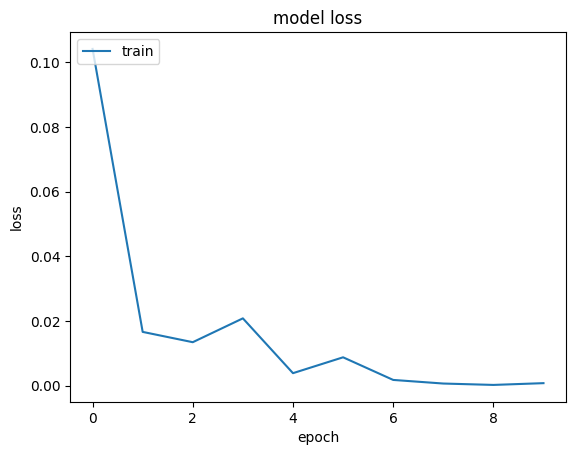

In [97]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [98]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 5s 88ms/step


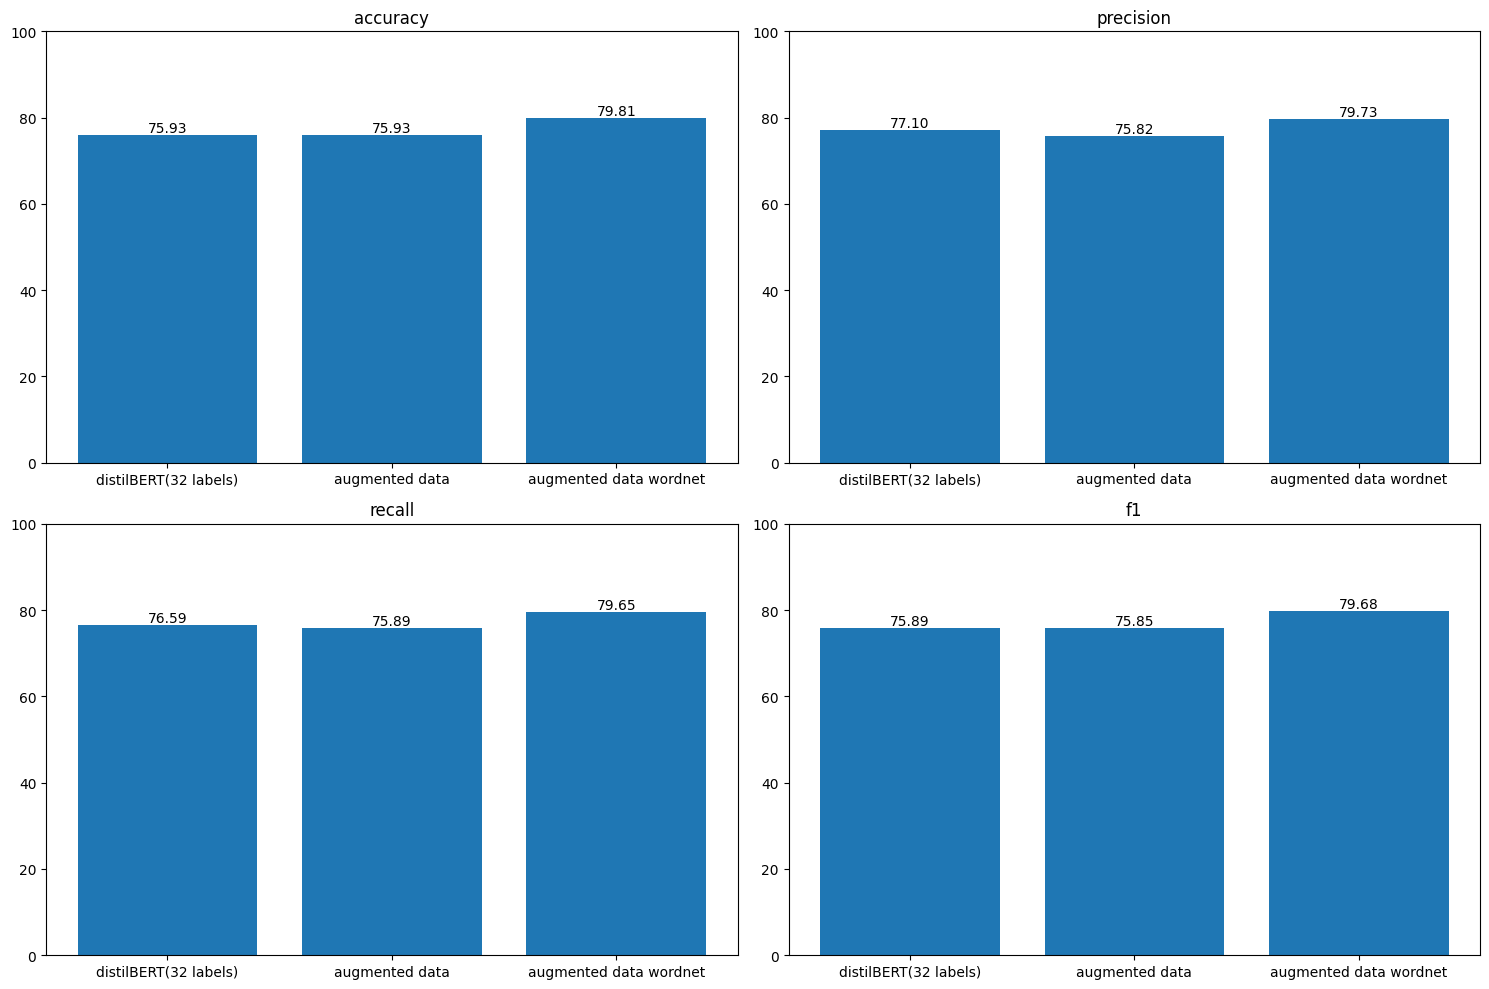

In [99]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data wordnet")
metrics_val.plot()
tf.keras.backend.clear_session()

---

# c. Zero-Shot Learning with LLM
#### For the Zero-Shot setup we found different LLM models from Huggingface which we tried to see which one gave us the best accuracy testing them with the validation data. Finally it was "facebook/bart-large-mnli" the one it gave us the best results

In [100]:
from transformers import pipeline

model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

df_val_sampled = df_val.sample(n=299, random_state=42)
sampled_list1 = (df_val_sampled['text']).tolist()

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

['negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'ne

In [101]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Update the "label" column with values from sampled_list2
df_val_sampled['label'] = zero_predictions

# Display the updated DataFrame
print(df_val_sampled.head())

                                                  text  label  text_length  \
281                          omfg! I'm angry on myself      0            5   
265             Im up finally , getting ready for work      1            8   
164  is insanely happy that her body finally got us...      1           26   
9                      Resident Evil 5 delivered today      1            5   
77   @wbaars i thought its a varient for violet , s...      0           10   

                                            clean_text clean_emotions hashtag  \
281                        omfg ! i am angry on myself                          
265             im up finally , getting ready for work                          
164  is insanely happy that her body finally got us...                          
9                        resident evil delivered today                          
77          i thought its a varient for violet , sorry                          

                                          te

#### Now we train our Roberta model once again adding the data obtained with Zero-Shot to the 32 labeled

In [102]:
# Add new_rows to df_train_32
augmented_zero_df = pd.concat([df_train_32, df_val_sampled], ignore_index=True)

# Display the augmented DataFrame
print(augmented_zero_df.shape)

(331, 7)


In [103]:
augmented_zero_df_data = augmented_zero_df['clean_text']
augmented_zero_df_label = augmented_zero_df['label']

In [104]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_zero_df_label).reshape(-1, 1)).toarray()

In [105]:
X_train = np.array(augmented_zero_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)




Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/7





Epoch:  10%|█         | 1/10 [00:26<04:00, 26.70s/it]

 1/10 [==>...........................] - ETA: 6:16 - loss: 1.5111 - recall: 0.8125 - precision: 0.8125




Epoch:  30%|███       | 3/10 [00:41<01:28, 12.58s/it]

 2/10 [=====>........................] - ETA: 3s - loss: 1.2995 - recall: 0.8281 - precision: 0.8281  




Epoch:  40%|████      | 4/10 [00:42<00:50,  8.38s/it]

 3/10 [========>.....................] - ETA: 2s - loss: 1.0973 - recall: 0.8438 - precision: 0.8438




Epoch:  50%|█████     | 5/10 [00:42<00:28,  5.73s/it]

 4/10 [===========>..................] - ETA: 2s - loss: 0.9005 - recall: 0.8594 - precision: 0.8594




Epoch:  60%|██████    | 6/10 [00:43<00:15,  3.98s/it]

 5/10 [==============>...............] - ETA: 1s - loss: 0.8362 - recall: 0.8625 - precision: 0.8625




Epoch:  70%|███████   | 7/10 [00:43<00:08,  2.84s/it]

 6/10 [=================>............] - ETA: 1s - loss: 0.7971 - recall: 0.8490 - precision: 0.8490




Epoch:  80%|████████  | 8/10 [00:43<00:04,  2.04s/it]

 7/10 [====================>.........] - ETA: 0s - loss: 0.7338 - recall: 0.8527 - precision: 0.8527




Epoch:  90%|█████████ | 9/10 [00:43<00:01,  1.50s/it]

 8/10 [=======================>......] - ETA: 0s - loss: 0.7060 - recall: 0.8477 - precision: 0.8477




Epoch: 100%|██████████| 10/10 [00:44<00:00,  1.15s/it]

 9/10 [==========================>...] - ETA: 0s - loss: 0.6691 - recall: 0.8403 - precision: 0.8403




Epoch: 11it [00:44,  1.10it/s]                        

10/10 [==============================] - 45s 330ms/step - loss: 0.6676 - recall: 0.8344 - precision: 0.8344
Epoch 2/7





Epoch: 12it [00:44,  1.38it/s]

 1/10 [==>...........................] - ETA: 2s - loss: 0.4926 - recall: 0.7273 - precision: 0.7273




Epoch: 13it [00:45,  1.68it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.3018 - recall: 0.8372 - precision: 0.8372




Epoch: 14it [00:45,  2.00it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.3743 - recall: 0.8267 - precision: 0.8267




Epoch: 15it [00:45,  2.31it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.3660 - recall: 0.8318 - precision: 0.8318




Epoch: 16it [00:46,  2.60it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.3580 - recall: 0.8345 - precision: 0.8345




Epoch: 17it [00:46,  2.84it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.3588 - recall: 0.8480 - precision: 0.8480




Epoch: 18it [00:46,  3.04it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.3635 - recall: 0.8522 - precision: 0.8522




Epoch: 19it [00:46,  3.21it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.3566 - recall: 0.8511 - precision: 0.8511




Epoch: 20it [00:47,  3.33it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.3422 - recall: 0.8614 - precision: 0.8614




Epoch: 21it [00:47,  3.14it/s]

10/10 [==============================] - 3s 286ms/step - loss: 0.3458 - recall: 0.8528 - precision: 0.8528
Epoch 3/7





Epoch: 22it [00:47,  3.22it/s]

 1/10 [==>...........................] - ETA: 2s - loss: 0.4052 - recall: 0.7812 - precision: 0.7812




Epoch: 23it [00:48,  3.34it/s]

 2/10 [=====>........................] - ETA: 1s - loss: 0.3580 - recall: 0.8140 - precision: 0.8140




Epoch: 24it [00:48,  3.75it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.2462 - recall: 0.8933 - precision: 0.8933




Epoch: 25it [00:48,  3.70it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.2315 - recall: 0.8972 - precision: 0.8972




Epoch: 26it [00:48,  3.72it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.2501 - recall: 0.8921 - precision: 0.8921




Epoch: 27it [00:49,  3.76it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.2305 - recall: 0.9006 - precision: 0.9006




Epoch: 28it [00:49,  3.70it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.2543 - recall: 0.8867 - precision: 0.8867




Epoch: 29it [00:49,  3.74it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.2391 - recall: 0.8936 - precision: 0.8936




Epoch: 30it [00:49,  3.78it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.2426 - recall: 0.8876 - precision: 0.8876




Epoch: 31it [00:50,  3.75it/s]

10/10 [==============================] - 3s 264ms/step - loss: 0.2332 - recall: 0.8896 - precision: 0.8896
Epoch 4/7





Epoch: 32it [00:50,  3.55it/s]

 1/10 [==>...........................] - ETA: 3s - loss: 0.2462 - recall: 0.9375 - precision: 0.9375




Epoch: 33it [00:50,  3.33it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.2144 - recall: 0.9375 - precision: 0.9375




Epoch: 34it [00:51,  3.21it/s]

 3/10 [========>.....................] - ETA: 2s - loss: 0.1875 - recall: 0.9467 - precision: 0.9467




Epoch: 35it [00:51,  3.35it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.1558 - recall: 0.9439 - precision: 0.9439




Epoch: 36it [00:51,  3.17it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.1441 - recall: 0.9496 - precision: 0.9496




Epoch: 37it [00:52,  3.07it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.1345 - recall: 0.9474 - precision: 0.9474




Epoch: 38it [00:52,  3.01it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.1354 - recall: 0.9458 - precision: 0.9458




Epoch: 39it [00:52,  3.12it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.1210 - recall: 0.9532 - precision: 0.9532




Epoch: 40it [00:53,  3.30it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.1110 - recall: 0.9588 - precision: 0.9588




Epoch: 41it [00:53,  3.38it/s]

10/10 [==============================] - 3s 310ms/step - loss: 0.1018 - recall: 0.9632 - precision: 0.9632
Epoch 5/7





Epoch: 42it [00:53,  3.37it/s]

 1/10 [==>...........................] - ETA: 2s - loss: 0.1846 - recall: 0.9062 - precision: 0.9062




Epoch: 43it [00:53,  3.44it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.1044 - recall: 0.9531 - precision: 0.9531




Epoch: 44it [00:54,  3.55it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.0957 - recall: 0.9479 - precision: 0.9479




Epoch: 45it [00:54,  3.56it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.0918 - recall: 0.9533 - precision: 0.9533




Epoch: 46it [00:54,  3.92it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.0749 - recall: 0.9640 - precision: 0.9640




Epoch: 47it [00:54,  3.80it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.0642 - recall: 0.9708 - precision: 0.9708




Epoch: 48it [00:55,  3.75it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.0555 - recall: 0.9754 - precision: 0.9754




Epoch: 49it [00:55,  3.78it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.0579 - recall: 0.9745 - precision: 0.9745




Epoch: 50it [00:55,  3.72it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.0513 - recall: 0.9775 - precision: 0.9775




Epoch: 51it [00:55,  3.74it/s]

10/10 [==============================] - 3s 262ms/step - loss: 0.0502 - recall: 0.9766 - precision: 0.9766
Epoch 6/7





Epoch: 52it [00:56,  3.72it/s]

 1/10 [==>...........................] - ETA: 2s - loss: 0.0384 - recall: 1.0000 - precision: 1.0000




Epoch: 53it [00:56,  3.76it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.0652 - recall: 0.9688 - precision: 0.9688




Epoch: 54it [00:56,  3.77it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.0695 - recall: 0.9688 - precision: 0.9688




Epoch: 55it [00:57,  3.72it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.0617 - recall: 0.9688 - precision: 0.9688




Epoch: 56it [00:57,  3.70it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.0569 - recall: 0.9712 - precision: 0.9712




Epoch: 57it [00:57,  4.04it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.0523 - recall: 0.9766 - precision: 0.9766




Epoch: 58it [00:57,  3.97it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.0546 - recall: 0.9754 - precision: 0.9754




Epoch: 59it [00:58,  3.87it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.0506 - recall: 0.9787 - precision: 0.9787




Epoch: 60it [00:58,  3.87it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.0577 - recall: 0.9775 - precision: 0.9775




Epoch: 61it [00:58,  3.83it/s]

10/10 [==============================] - 3s 262ms/step - loss: 0.0600 - recall: 0.9766 - precision: 0.9766
Epoch 7/7





Epoch: 62it [00:58,  3.67it/s]

 1/10 [==>...........................] - ETA: 2s - loss: 0.0588 - recall: 0.9688 - precision: 0.9688




Epoch: 63it [00:59,  3.70it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.0299 - recall: 0.9844 - precision: 0.9844




Epoch: 64it [00:59,  3.74it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.0329 - recall: 0.9792 - precision: 0.9792




Epoch: 65it [00:59,  3.77it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.0418 - recall: 0.9688 - precision: 0.9688




Epoch: 66it [00:59,  3.67it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.0340 - recall: 0.9750 - precision: 0.9750




Epoch: 67it [01:00,  3.73it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.0319 - recall: 0.9766 - precision: 0.9766




Epoch: 68it [01:00,  4.05it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.0278 - recall: 0.9803 - precision: 0.9803




Epoch: 69it [01:00,  3.99it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.0256 - recall: 0.9830 - precision: 0.9830




Epoch: 70it [01:00,  3.87it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.0279 - recall: 0.9813 - precision: 0.9813




Epoch: 71it [01:01,  3.79it/s]

10/10 [==============================] - 3s 263ms/step - loss: 0.0291 - recall: 0.9833 - precision: 0.9833


In [106]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(validation_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

10/10 [==============================] - 5s 86ms/step


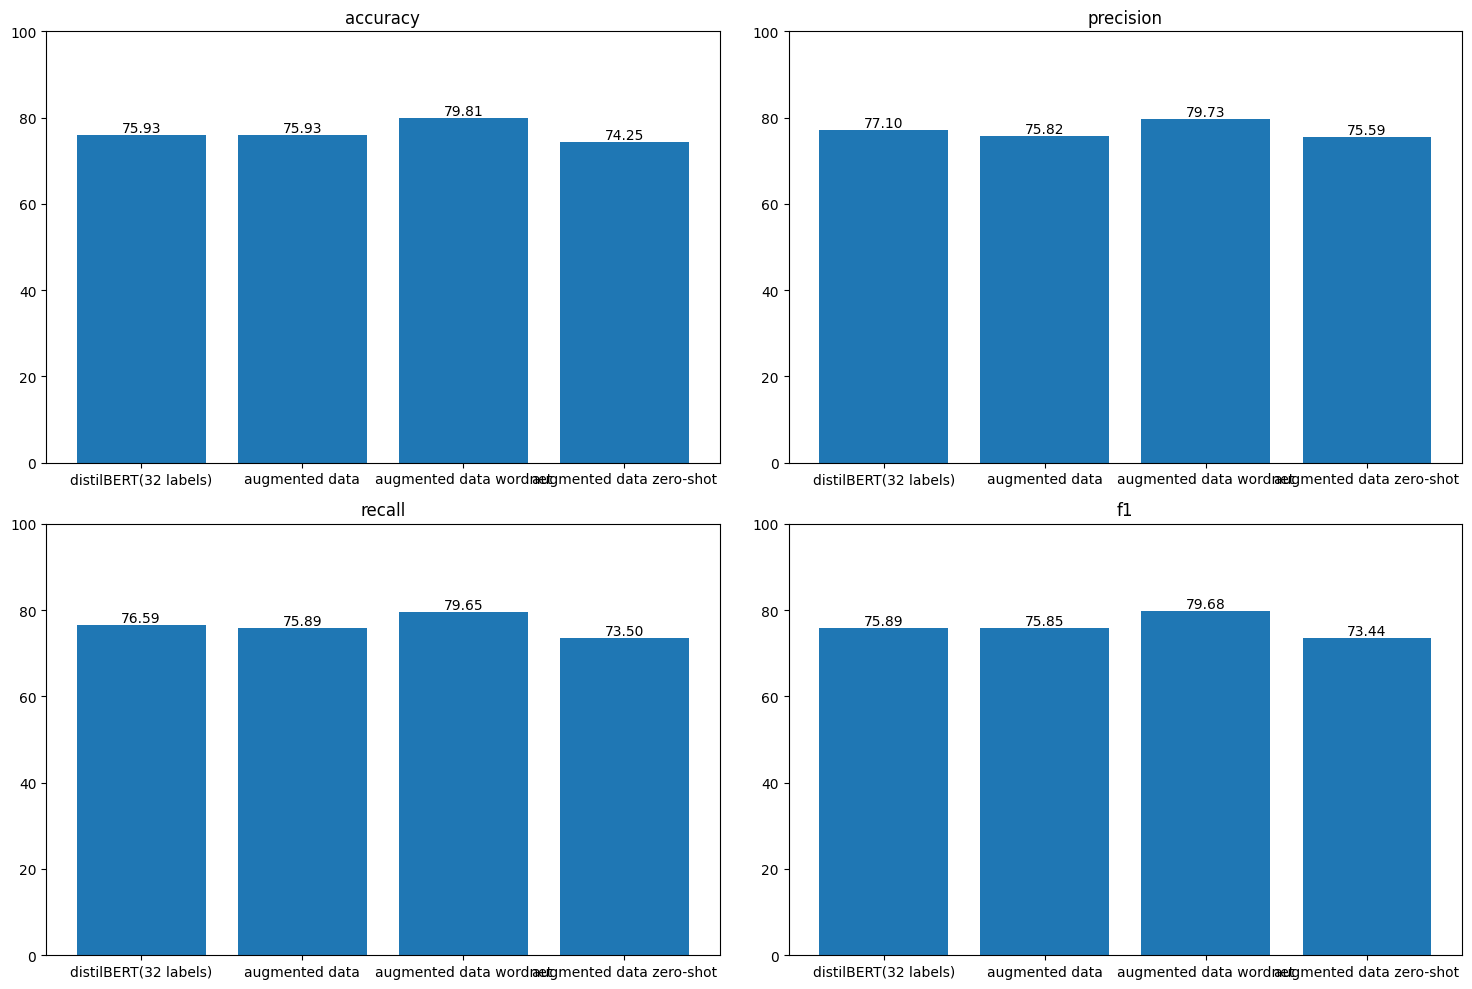

In [107]:
# get the final metrics
metrics_val.run(validation_labels, valid_preds, "augmented data zero-shot")
metrics_val.plot()
tf.keras.backend.clear_session()

#### We get a very big increase in the performance of our model, probably because of the size of the data, since we were training our model with only 32 samples and now we are adding 300 more samples, even though they are not 100% accurate, is still gives a lot more information for the model to work better

---

# d. Data Generation with LLM

In [108]:
# Output path to keep the generated answers:
path_output = []

prompts = []

initial_prompt = """
Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment labeling scheme.

Additional Instructions:
- Ensure that the generated tweets are coherent, grammatically correct, and resemble natural Twitter language.
- Aim for diversity in the generated tweets to cover a wide range of sentiment expressions.
- Pay attention to the sentiment labels assigned to each generated tweet, maintaining consistency with the labeling scheme.

Data Format:
- Each generated tweet should be accompanied by its corresponding sentiment label (1 for positive, 0 for negative) and the context.
- Output format: Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]

Example Output:
Tweet_: "Just finished watching the latest episode of my favorite TV show! Absolutely loved it!" Sentiment_: 1 Context_: "Normal"
Tweet_: "Stuck in traffic again! This commute is unbearable." Sentiment_: 0 Context_: "Normal"

The next ("PROMPT") will follow this structure:
"Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]"

Where Number is equal to the number of tweets to generate, Sentiment will be positive or negative.
And Context will be one of the following options [Normal, Sarcasm, Irony] where you adapt the generated tweets to the given context.
"""

following_prompts = """
Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]
"""

following_prompts = Template(following_prompts)
sentiment_list = ["positive","negative"]
context_list = ['Normal','Normal','Sarcasm','Irony'] # Two times 'Normal' to have more of these

In [109]:
print(initial_prompt)


Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment

In [110]:
print(following_prompts.render(number=50, sentiment="positive", context="Normal"))


Please generate 50 positive tweets with the following context Normal. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]


In [111]:
#client = OpenAI(api_key=tatiana_key)

In [112]:
# As only 50 tweets are asked in each prompt, we multiply the number of demands by 3.
all_prompts = [initial_prompt] + 3*[following_prompts.render(number=50,sentiment="negative", context=con) for con in context_list] + 3*[following_prompts.render(number=50,sentiment="positive", context=con) for con in context_list]
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]

In [113]:
"""gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"""

"gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"

In [114]:
"""print(len(gpt_tweets))
gpt_tweets[1]"""

'print(len(gpt_tweets))\ngpt_tweets[1]'

Save the generated tweets in a csv file to reduce the number of GPT requests made.

In [115]:
"""
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Tweet', 'Sentiment', 'Context'])

# Iterate through each element in gpt_tweets starting from index 1
for tweet_info_set in gpt_tweets[1:]:
    # Split the element by newline character to separate the lines
    tweet_info_lines = tweet_info_set.split('\n')

    # Initialize variables to store tweet, sentiment, and context
    tweet = []
    sentiment = []
    context = []

    # Iterate through each line in the tweet_info_lines
    for twt in tweet_info_lines:
        # Extract tweet, sentiment, and context from each line
        if "Tweet_:" in twt or "Tweet:" in twt:
          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]
          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]
          tweet.append(tweet_)

        if "Sentiment_:" in twt or "Sentiment:" in twt:
          sentiment_ = twt.split("Sentiment_:")[1].split() if "Sentiment_:" in twt else twt.split("Sentiment:")[1]
          sentiment_ = sentiment_[0] if sentiment_[0] in ["1","0"] else sentiment_[1]
          sentiment.append(sentiment_)

        if "Context_:" in twt or "Context:" in twt:
          context_ = twt.split("Context_:")[1] if "Context_:" in twt else twt.split("Context:")[1]
          context.append(context_)

    # Check they all have the same length
    if len(tweet) == len(sentiment) == len(context):
        # Create a DataFrame from the extracted tweet, sentiment, and context
        df = pd.concat([df, pd.DataFrame({'Tweet': tweet, 'Sentiment': sentiment, 'Context': context})], ignore_index=True)
    else:
      print("An error has occured the data is not correct!")

# Display the DataFrame
df.head()
"""

'\n# Initialize an empty DataFrame\ndf = pd.DataFrame(columns=[\'Tweet\', \'Sentiment\', \'Context\'])\n\n# Iterate through each element in gpt_tweets starting from index 1\nfor tweet_info_set in gpt_tweets[1:]:\n    # Split the element by newline character to separate the lines\n    tweet_info_lines = tweet_info_set.split(\'\n\')\n\n    # Initialize variables to store tweet, sentiment, and context\n    tweet = []\n    sentiment = []\n    context = []\n\n    # Iterate through each line in the tweet_info_lines\n    for twt in tweet_info_lines:\n        # Extract tweet, sentiment, and context from each line\n        if "Tweet_:" in twt or "Tweet:" in twt:\n          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]\n          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]\n          tweet.append(tweet_)\n\n        if "Sentiment_:" in twt or "Sentiment:" in twt:\n          sentiment_ = twt.split("Sentimen

In [116]:
"""# Save the tweets into a csv format:
from google.colab import drive
drive.mount('/content/drive')

# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.
df.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"""

"# Save the tweets into a csv format:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.\ndf.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"

In [117]:
# Load csv file containing the generated tweets
df = pd.read_csv("/content/gpt_tweets.csv")

df['Context'] = df['Context'].str.strip()

df.rename(columns={'Tweet': 'text', 'Sentiment': 'label'}, inplace=True)

In [118]:
# Inspect Data
print(df.shape)
df.isna().sum()

(1135, 3)


text       0
label      0
Context    0
dtype: int64

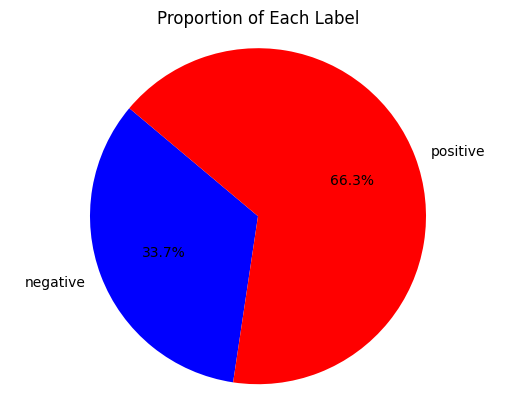

In [119]:
# Check Positive vs Negative Ratio:
label_counts = Counter(df['label'])
labels = {0: 'negative', 1: 'positive'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Label')
plt.show()

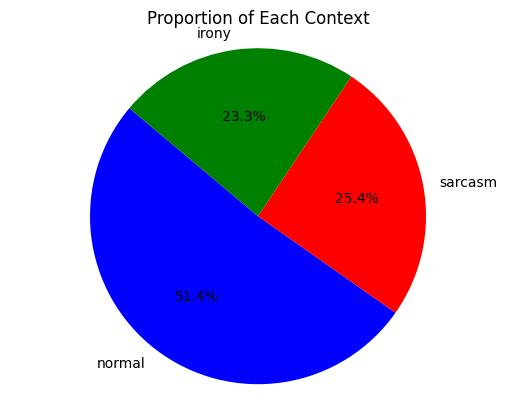

In [120]:
# Check Context Ratio:
label_counts = Counter(df['Context'])
labels = {'Normal': 'normal', 'Sarcasm': 'sarcasm', 'Irony':'irony'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red', 'green']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Context')
plt.show()

In [121]:
# 5 examples of each tweet category possible, (positive vs negative), (Normal, Irony, Sarcasm)
unique_contexts = df['Context'].unique()

# Iterate over each unique context
for context in unique_contexts:
    print(f"Context: {context}")
    # Filter the DataFrame for the current context
    context_df = df[df['Context'] == context]
    # Filter positive tweets
    positive_tweets = context_df[context_df['label'] == 1]['text'].head(5)
    print("Positive Tweets:")
    for tweet in positive_tweets:
        print(tweet)
    # Filter negative tweets
    negative_tweets = context_df[context_df['label'] == 0]['text'].head(5)
    print("Negative Tweets:")
    for tweet in negative_tweets:
        print(tweet)
    print()

Context: Normal
Positive Tweets:
 Love starting my day with a cup of coffee and some good music! 
 Grateful for the sunny weather today, it's such a mood booster! 
 Just finished a great workout and feeling energized for the day ahead. 
 Spending time with loved ones always puts a smile on my face. 
 Excited to dive into a new book I've been waiting to read! 
Negative Tweets:
 Normal is overrated. 
 Can't stand being average, but that's what normal is all about. 
 Normal is just code for boring. 
 The idea of being normal makes me cringe. 
 Trying to fit in with the norm is exhausting. 

Context: Sarcasm
Positive Tweets:
 I just love when people take up two parking spots. So considerate. 
 I always look forward to getting stuck in traffic. It's the highlight of my day. 
 Ah, nothing like waking up to a pile of dirty dishes in the sink. Pure bliss. 
 Can't get enough of spam emails. They really brighten up my inbox. 
 Oh, I absolutely adore it when my phone dies right in the middle of a

In [122]:
df['text_length'] = 0
df = clean_text(df)

train_data_generated = df["text"]
train_labels_generated = df["label"]

In [123]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_generated).reshape(-1, 1)).toarray()

In [124]:
X_train = np.array(train_data_generated)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)





Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/2






Epoch:   3%|▎         | 1/35 [00:27<15:29, 27.35s/it]

 1/35 [..............................] - ETA: 24:21 - loss: 1.4706 - recall: 0.8438 - precision: 0.8438





Epoch:   9%|▊         | 3/35 [00:43<06:54, 12.96s/it]

 2/35 [>.............................] - ETA: 15s - loss: 0.8588 - recall: 0.8594 - precision: 0.8594  





Epoch:  11%|█▏        | 4/35 [00:43<04:27,  8.63s/it]

 3/35 [=>............................] - ETA: 13s - loss: 0.7712 - recall: 0.8750 - precision: 0.8750





Epoch:  14%|█▍        | 5/35 [00:44<02:56,  5.90s/it]

 4/35 [==>...........................] - ETA: 12s - loss: 0.9304 - recall: 0.8438 - precision: 0.8438





Epoch:  17%|█▋        | 6/35 [00:44<01:59,  4.12s/it]

 5/35 [===>..........................] - ETA: 11s - loss: 0.9247 - recall: 0.8375 - precision: 0.8375





Epoch:  20%|██        | 7/35 [00:44<01:22,  2.94s/it]

 6/35 [====>.........................] - ETA: 10s - loss: 0.8693 - recall: 0.8438 - precision: 0.8438





Epoch:  23%|██▎       | 8/35 [00:45<00:57,  2.11s/it]

 7/35 [=====>........................] - ETA: 9s - loss: 0.8805 - recall: 0.8304 - precision: 0.8304 





Epoch:  26%|██▌       | 9/35 [00:45<00:40,  1.55s/it]

 8/35 [=====>........................] - ETA: 9s - loss: 0.8416 - recall: 0.8320 - precision: 0.8320





Epoch:  29%|██▊       | 10/35 [00:45<00:29,  1.19s/it]

 9/35 [======>.......................] - ETA: 8s - loss: 0.8226 - recall: 0.8299 - precision: 0.8299





Epoch:  31%|███▏      | 11/35 [00:45<00:21,  1.10it/s]

10/35 [=======>......................] - ETA: 8s - loss: 0.7791 - recall: 0.8281 - precision: 0.8281





Epoch:  34%|███▍      | 12/35 [00:46<00:16,  1.40it/s]

11/35 [========>.....................] - ETA: 7s - loss: 0.7247 - recall: 0.8324 - precision: 0.8324





Epoch:  37%|███▋      | 13/35 [00:46<00:12,  1.71it/s]

12/35 [=========>....................] - ETA: 7s - loss: 0.7201 - recall: 0.8255 - precision: 0.8255





Epoch:  40%|████      | 14/35 [00:46<00:10,  2.03it/s]

13/35 [==========>...................] - ETA: 7s - loss: 0.7131 - recall: 0.8149 - precision: 0.8149





Epoch:  43%|████▎     | 15/35 [00:47<00:08,  2.32it/s]

14/35 [===========>..................] - ETA: 6s - loss: 0.7057 - recall: 0.8125 - precision: 0.8125





Epoch:  46%|████▌     | 16/35 [00:47<00:07,  2.60it/s]

15/35 [===========>..................] - ETA: 6s - loss: 0.6873 - recall: 0.8125 - precision: 0.8125





Epoch:  49%|████▊     | 17/35 [00:47<00:06,  2.65it/s]

16/35 [============>.................] - ETA: 6s - loss: 0.6697 - recall: 0.8105 - precision: 0.8105





Epoch:  51%|█████▏    | 18/35 [00:48<00:06,  2.66it/s]

17/35 [=============>................] - ETA: 5s - loss: 0.6599 - recall: 0.8070 - precision: 0.8070





Epoch:  54%|█████▍    | 19/35 [00:48<00:05,  2.89it/s]

18/35 [==============>...............] - ETA: 5s - loss: 0.6389 - recall: 0.8125 - precision: 0.8125





Epoch:  57%|█████▋    | 20/35 [00:48<00:05,  2.84it/s]

19/35 [===============>..............] - ETA: 5s - loss: 0.6290 - recall: 0.8092 - precision: 0.8092





Epoch:  60%|██████    | 21/35 [00:48<00:04,  3.08it/s]

20/35 [================>.............] - ETA: 4s - loss: 0.6239 - recall: 0.8094 - precision: 0.8094





Epoch:  63%|██████▎   | 22/35 [00:49<00:04,  3.20it/s]

21/35 [=================>............] - ETA: 4s - loss: 0.6236 - recall: 0.8095 - precision: 0.8095





Epoch:  66%|██████▌   | 23/35 [00:49<00:03,  3.36it/s]

22/35 [=================>............] - ETA: 4s - loss: 0.6064 - recall: 0.8153 - precision: 0.8153





Epoch:  69%|██████▊   | 24/35 [00:49<00:03,  3.42it/s]

23/35 [==================>...........] - ETA: 3s - loss: 0.5990 - recall: 0.8139 - precision: 0.8139





Epoch:  71%|███████▏  | 25/35 [00:50<00:02,  3.45it/s]

24/35 [===================>..........] - ETA: 3s - loss: 0.5912 - recall: 0.8164 - precision: 0.8164





Epoch:  74%|███████▍  | 26/35 [00:50<00:02,  3.23it/s]

25/35 [====================>.........] - ETA: 3s - loss: 0.5847 - recall: 0.8175 - precision: 0.8175





Epoch:  77%|███████▋  | 27/35 [00:50<00:02,  3.30it/s]

26/35 [=====================>........] - ETA: 2s - loss: 0.5735 - recall: 0.8209 - precision: 0.8209





Epoch:  80%|████████  | 28/35 [00:50<00:02,  3.45it/s]

27/35 [======================>.......] - ETA: 2s - loss: 0.5582 - recall: 0.8275 - precision: 0.8275





Epoch:  83%|████████▎ | 29/35 [00:51<00:01,  3.55it/s]

28/35 [=======================>......] - ETA: 2s - loss: 0.5537 - recall: 0.8270 - precision: 0.8270





Epoch:  86%|████████▌ | 30/35 [00:51<00:01,  3.54it/s]

29/35 [=======================>......] - ETA: 1s - loss: 0.5451 - recall: 0.8287 - precision: 0.8287





Epoch:  89%|████████▊ | 31/35 [00:51<00:01,  3.56it/s]

30/35 [========================>.....] - ETA: 1s - loss: 0.5399 - recall: 0.8292 - precision: 0.8292





Epoch:  91%|█████████▏| 32/35 [00:52<00:00,  3.54it/s]

31/35 [=========================>....] - ETA: 1s - loss: 0.5320 - recall: 0.8317 - precision: 0.8317





Epoch:  94%|█████████▍| 33/35 [00:52<00:00,  3.56it/s]

32/35 [==========================>...] - ETA: 0s - loss: 0.5236 - recall: 0.8340 - precision: 0.8340





Epoch:  97%|█████████▋| 34/35 [00:52<00:00,  3.33it/s]

33/35 [===========================>..] - ETA: 0s - loss: 0.5193 - recall: 0.8343 - precision: 0.8343





Epoch: 100%|██████████| 35/35 [00:52<00:00,  3.42it/s]

34/35 [============================>.] - ETA: 0s - loss: 0.5161 - recall: 0.8327 - precision: 0.8327





Epoch: 36it [00:53,  3.24it/s]                        

35/35 [==============================] - 53s 309ms/step - loss: 0.5074 - recall: 0.8357 - precision: 0.8357
Epoch 2/2






Epoch: 37it [00:53,  3.05it/s]

 1/35 [..............................] - ETA: 9s - loss: 0.4294 - recall: 0.8667 - precision: 0.8667





Epoch: 38it [00:53,  3.13it/s]

 2/35 [>.............................] - ETA: 9s - loss: 0.2778 - recall: 0.8936 - precision: 0.8936





Epoch: 39it [00:54,  3.27it/s]

 3/35 [=>............................] - ETA: 8s - loss: 0.2894 - recall: 0.8987 - precision: 0.8987





Epoch: 40it [00:54,  3.38it/s]

 4/35 [==>...........................] - ETA: 8s - loss: 0.2801 - recall: 0.8919 - precision: 0.8919





Epoch: 41it [00:54,  3.50it/s]

 5/35 [===>..........................] - ETA: 8s - loss: 0.2691 - recall: 0.8811 - precision: 0.8811





Epoch: 42it [00:55,  3.56it/s]

 6/35 [====>.........................] - ETA: 7s - loss: 0.2571 - recall: 0.8857 - precision: 0.8857





Epoch: 43it [00:55,  3.63it/s]

 7/35 [=====>........................] - ETA: 7s - loss: 0.2408 - recall: 0.8937 - precision: 0.8937





Epoch: 44it [00:55,  3.63it/s]

 8/35 [=====>........................] - ETA: 7s - loss: 0.2580 - recall: 0.8996 - precision: 0.8996





Epoch: 45it [00:55,  3.67it/s]

 9/35 [======>.......................] - ETA: 7s - loss: 0.2894 - recall: 0.8893 - precision: 0.8893





Epoch: 46it [00:56,  3.64it/s]

10/35 [=======>......................] - ETA: 6s - loss: 0.2775 - recall: 0.8977 - precision: 0.8977





Epoch: 47it [00:56,  3.66it/s]

11/35 [========>.....................] - ETA: 6s - loss: 0.2890 - recall: 0.8925 - precision: 0.8925





Epoch: 48it [00:56,  3.68it/s]

12/35 [=========>....................] - ETA: 6s - loss: 0.2838 - recall: 0.8937 - precision: 0.8937





Epoch: 49it [00:56,  3.72it/s]

13/35 [==========>...................] - ETA: 5s - loss: 0.2800 - recall: 0.8922 - precision: 0.8922





Epoch: 50it [00:57,  3.64it/s]

14/35 [===========>..................] - ETA: 5s - loss: 0.2742 - recall: 0.8933 - precision: 0.8933





Epoch: 51it [00:57,  3.60it/s]

15/35 [===========>..................] - ETA: 5s - loss: 0.2711 - recall: 0.8985 - precision: 0.8985





Epoch: 52it [00:57,  3.67it/s]

16/35 [============>.................] - ETA: 5s - loss: 0.2599 - recall: 0.9030 - precision: 0.9030





Epoch: 53it [00:58,  3.65it/s]

17/35 [=============>................] - ETA: 4s - loss: 0.2664 - recall: 0.8994 - precision: 0.8994





Epoch: 54it [00:58,  3.69it/s]

18/35 [==============>...............] - ETA: 4s - loss: 0.2586 - recall: 0.9016 - precision: 0.9016





Epoch: 55it [00:58,  3.31it/s]

19/35 [===============>..............] - ETA: 4s - loss: 0.2601 - recall: 0.9002 - precision: 0.9002





Epoch: 56it [00:58,  3.45it/s]

20/35 [================>.............] - ETA: 4s - loss: 0.2603 - recall: 0.9005 - precision: 0.9005





Epoch: 57it [00:59,  3.54it/s]

21/35 [=================>............] - ETA: 3s - loss: 0.2636 - recall: 0.8992 - precision: 0.8992





Epoch: 58it [00:59,  3.52it/s]

22/35 [=================>............] - ETA: 3s - loss: 0.2550 - recall: 0.9039 - precision: 0.9039





Epoch: 59it [00:59,  3.61it/s]

23/35 [==================>...........] - ETA: 3s - loss: 0.2494 - recall: 0.9054 - precision: 0.9054





Epoch: 60it [01:00,  3.68it/s]

24/35 [===================>..........] - ETA: 3s - loss: 0.2509 - recall: 0.9041 - precision: 0.9041





Epoch: 61it [01:00,  3.71it/s]

25/35 [====================>.........] - ETA: 2s - loss: 0.2466 - recall: 0.9055 - precision: 0.9055





Epoch: 62it [01:00,  3.70it/s]

26/35 [=====================>........] - ETA: 2s - loss: 0.2454 - recall: 0.9055 - precision: 0.9055





Epoch: 63it [01:00,  3.70it/s]

27/35 [======================>.......] - ETA: 2s - loss: 0.2398 - recall: 0.9079 - precision: 0.9079





Epoch: 64it [01:01,  3.73it/s]

28/35 [=======================>......] - ETA: 1s - loss: 0.2326 - recall: 0.9113 - precision: 0.9113





Epoch: 65it [01:01,  3.74it/s]

29/35 [=======================>......] - ETA: 1s - loss: 0.2464 - recall: 0.9100 - precision: 0.9100





Epoch: 66it [01:01,  3.75it/s]

30/35 [========================>.....] - ETA: 1s - loss: 0.2437 - recall: 0.9109 - precision: 0.9109





Epoch: 67it [01:01,  3.73it/s]

31/35 [=========================>....] - ETA: 1s - loss: 0.2411 - recall: 0.9118 - precision: 0.9118





Epoch: 68it [01:02,  3.74it/s]

32/35 [==========================>...] - ETA: 0s - loss: 0.2502 - recall: 0.9057 - precision: 0.9057





Epoch: 69it [01:02,  3.75it/s]

33/35 [===========================>..] - ETA: 0s - loss: 0.2442 - recall: 0.9086 - precision: 0.9086





Epoch: 70it [01:02,  3.69it/s]

34/35 [============================>.] - ETA: 0s - loss: 0.2460 - recall: 0.9076 - precision: 0.9076





Epoch: 71it [01:02,  3.67it/s]

35/35 [==============================] - 10s 273ms/step - loss: 0.2454 - recall: 0.9075 - precision: 0.9075


In [125]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 5s 85ms/step


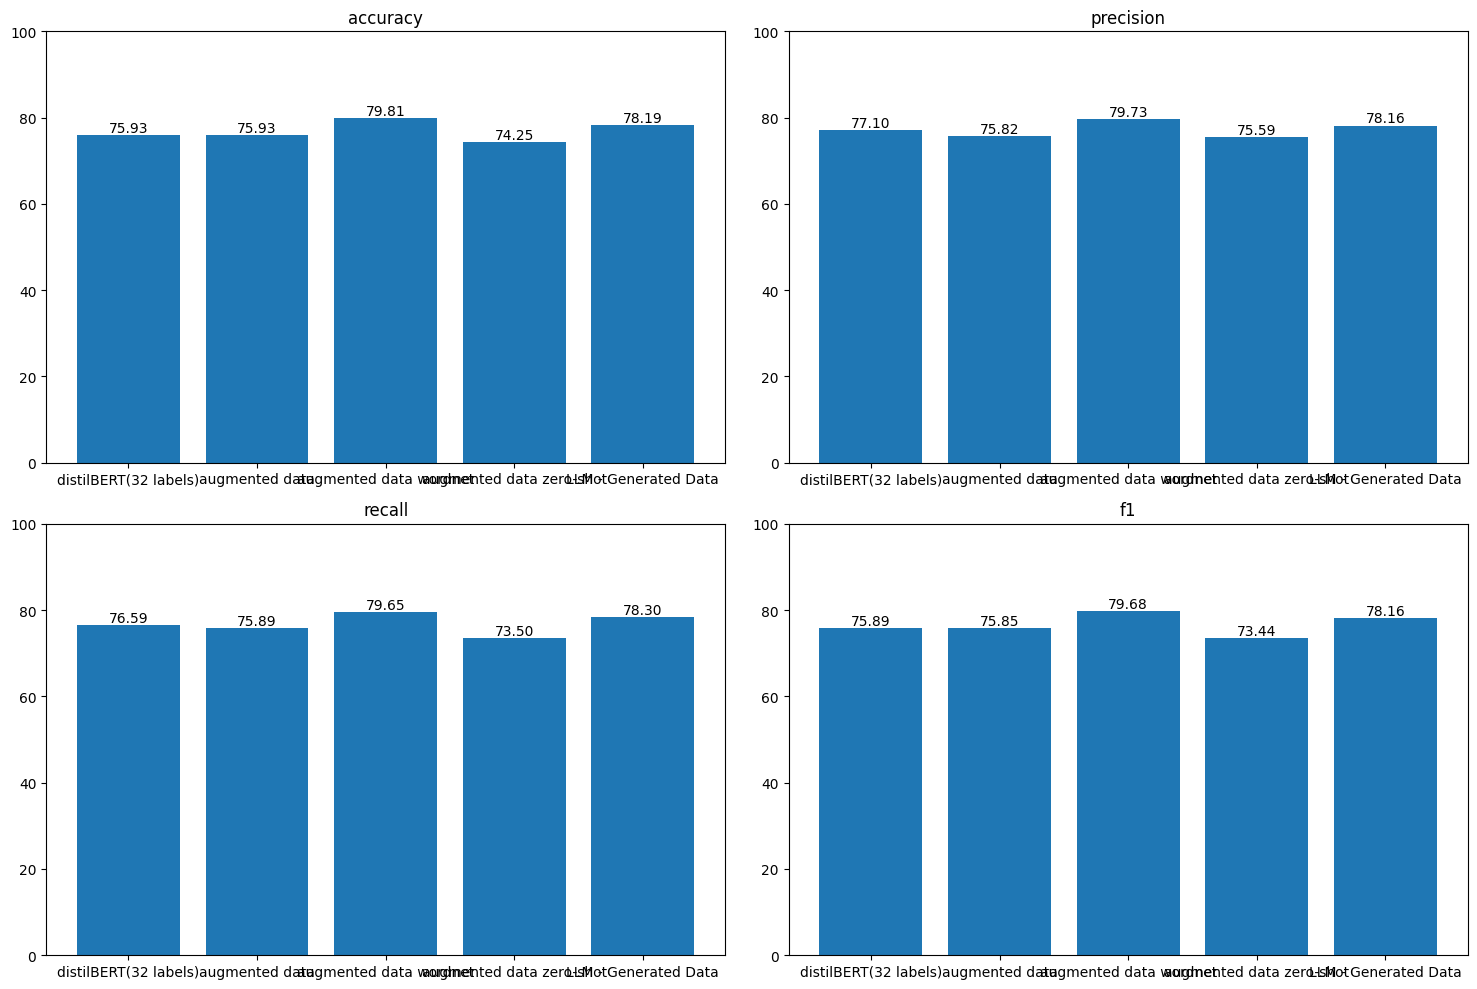

In [127]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "LLM - Generated Data")
metrics_val.plot()
tf.keras.backend.clear_session()

# e. Optimal Technique Application

---

# Part 3: State of the Art Comparison
## a. Full Dataset Training

In [131]:
metrics_tech = Metrics()

In [128]:
# Define observation shares
observation_shares = [0.01, 0.10, 0.25, 0.5, 0.75, 1]

# List to store validation predictions for all models
all_valid_preds = []

# List to store histories for all models
all_histories = []

for share in observation_shares:
    # Calculate the number of observations
    obs_count = int(len(df_train) * share)

    # Sample from the DataFrame
    df_train_sampled = df_train.sample(n=obs_count)

    # Extract features and labels
    train_data_sampled = df_train_sampled['clean_text']
    train_labels_sampled = df_train_sampled['label']

    # One-hot encode the labels
    enc = OneHotEncoder(handle_unknown='ignore')
    y_train_sampled = enc.fit_transform(np.array(train_labels_sampled).reshape(-1, 1)).toarray()

    # Get validation data
    # validation_data = df_validation['clean_text']
    # validation_labels = df_validation['label']

    # Convert validation labels to one-hot encoding
    y_valid = enc.transform(np.array(validation_labels).reshape(-1, 1)).toarray()

    # Define steps per epoch
    steps_per_epoch = int(len(X_train)/batch_size)

    # Generate batches for training data
    train_batches = get_batches(train_data_sampled, y_train_sampled, tokenizer, batch_size, max_length)

    # Generate batches for validation data
    valid_batches = get_batches(validation_data, y_valid, tokenizer, batch_size, max_length)

    # Compile the model
    bert_model.compile(
        optimizer=Adam(2e-5),
        metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
        loss=tf.keras.losses.CategoricalCrossentropy()
    )

    # Train the model and record the history
    history = bert_model.fit(
        train_batches,
        epochs=5,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_batches,
        validation_steps=len(validation_data) // batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
    )

    # Append the history to the list
    all_histories.append(history)

    # Get the inputs tokenized from the validation set
    inputs = tokenizer.batch_encode_plus(list(test_data),
                                         add_special_tokens=True,
                                         max_length=max_length,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_token_type_ids=True,
                                         truncation=True)

    # Extract input_ids and attention mask
    inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
                    np.asarray(inputs['attention_mask'], dtype='int32')]

    # Get predictions for the validation set
    valid_preds = bert_model.predict(inputs_valid)
    valid_preds = np.argmax(valid_preds, axis=1)

    # Append predictions to the list
    all_valid_preds.append(valid_preds)
    metrics_val.run(test_labels, valid_preds, f"share_{int(share * 100)}%")
    tf.keras.backend.clear_session()

Epoch 1/5


35/35 [==============================] - 71s 474ms/step - loss: 7.9915e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.0262 - val_recall: 0.7674 - val_precision: 0.7674
Epoch 2/5
35/35 [==============================] - 9s 257ms/step - loss: 4.5394e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.0673 - val_recall: 0.7678 - val_precision: 0.7678
Epoch 3/5
35/35 [==============================] - 8s 238ms/step - loss: 3.3483e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.9367 - val_recall: 0.7790 - val_precision: 0.7790
Epoch 4/5
35/35 [==============================] - 7s 192ms/step - loss: 5.5481e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.3779 - val_recall: 0.7603 - val_precision: 0.7603
Epoch 5/5
20/20 [==============================] - 5s 87ms/step


NameError: name 'keras' is not defined

## b. Learning Curve

In [ ]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot losses for all histories
for i, history in enumerate(all_histories):
    # Extract training and validation losses
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot training and validation losses
    ax.plot(train_loss, label=f'Train Loss (Share: {int(observation_shares[i] * 100)}%)', linestyle='--')
    ax.plot(val_loss, label=f'Validation Loss (Share: {int(observation_shares[i] * 100)}%)')

# Set title and labels
ax.set_title('Training and Validation Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Show plot
plt.show()

## c. Technique Comparison
## Pre-train the (freezed) model with the different techniques explored before

In [129]:
# Apply the different techniques and compare their perfromance
# 1. 32 label, 2. Synonyms, 3. Zero Shot, 4. LLM Tweets
techniques_names = ["32 Labels","Augmented Synonyms","Zero Shot","Generated Tweets"]
techniques = [[train_data_32,train_labels_32], [augmented_df_data,augmented_df_label], [augmented_zero_df_data, augmented_zero_df_label],[train_data_generated,train_labels_generated]]

In [ ]:
histories = []

for train_tec,y_tec in techniques:
    i = 0
    print("Model :",techniques_names[i])
    bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
    # To freeze BERT parameters (look at the trainable parameters below)
    bert_model.layers[2].trainable = False

    X_train = np.array(train_tec)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(y_tec).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train)/batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

    print("Fit Freezed layer...")
    bert_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

    # Test the model
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]

    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_tech.run(test_labels, test_preds, f"Froozen + {techniques_names[i]}")

    print("Fit unfreezd layer...")
    bert_model.layers[2].trainable = True

    steps_per_epoch = int(len(train_data)/batch_size)
    X_train = np.array(train_data_clean)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

    # Train on the whole NN
    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                      metrics=[tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision()],
                      loss=tf.keras.losses.CategoricalCrossentropy())

    hitory = bert_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)
    histories.append(history)

    # Get the inputs tokenized from the test set
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]
    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_tech.run(test_labels, test_preds, f"Unfrozen {techniques_names[i]}")
    tf.keras.backend.clear_session()
    i = i+1

metrics_tech.plot()

Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
1/1 [==============================] - 19s 19s/step - loss: 2.3842e-06 - recall_2: 1.0000 - precision_2: 1.0000
Epoch 2/2
20/20 [==============================] - 5s 87ms/step
Fit unfreezd layer...
Epoch 1/2


37/37 [==============================] - 75s 308ms/step - loss: 0.8679 - recall_3: 0.7492 - precision_3: 0.7492
Epoch 2/2
20/20 [==============================] - 5s 87ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
21/21 [==============================] - 17s 102ms/step - loss: 0.1459 - recall: 0.9479 - precision: 0.9479
Epoch 2/2
20/20 [==============================] - 5s 89ms/step
Fit unfreezd layer...
Epoch 1/2


37/37 [==============================] - 57s 310ms/step - loss: 0.3631 - recall_1: 0.8581 - precision_1: 0.8581
Epoch 2/2
20/20 [==============================] - 5s 90ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
10/10 [==============================] - 15s 105ms/step - loss: 0.2406 - recall: 0.8875 - precision: 0.8875
Epoch 2/2
20/20 [==============================] - 5s 89ms/step
Fit unfreezd layer...
Epoch 1/2


37/37 [==============================] - 56s 312ms/step - loss: 0.1911 - recall_1: 0.9443 - precision_1: 0.9443
Epoch 2/2
20/20 [==============================] - 5s 90ms/step
Model : 32 Labels
Fit Freezed layer...
Epoch 1/2
35/35 [==============================] - 18s 98ms/step - loss: 0.3096 - recall: 0.9045 - precision: 0.9045
Epoch 2/2
20/20 [==============================] - 5s 91ms/step
Fit unfreezd layer...
Epoch 1/2


In [ ]:
# Order the histories by the validation loss
histories = sorted(histories, key=lambda x: x[0].history['val_loss'][-1])

df_histories = pd.DataFrame(histories, columns=['history','loss','val_loss'])

# Print the results in order:
results = df_histories
results = results.sort_values(by='val_loss', ascending=True)

means = results['loss']
dev = results['val_loss']
for mean, stdev, param in zip(means, dev, techniques_names):
    print(f"Model {techniques_names[i]} %f (%f) with: %r" % (mean, stdev, param))

## d. Methodology Analysis

# Part 4: Model Distillation
## a. Model Distillation

In [ ]:
import time
class Distiller(tf.keras.Model):

    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3,):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False):

        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature, axis=1),
            tf.nn.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


In [ ]:
# Create the teacher
teacher = tf.keras.models.clone_model(bert_model)

# Create the student model on "distilbert/distilroberta-base"
checkpoint_distil="distilbert/distilroberta-base"
tokenizer_distil = AutoTokenizer.from_pretrained(checkpoint_distil)
model_distil = TFAutoModel.from_pretrained(checkpoint_distil)

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_distil(input_ids_in, attention_mask=input_masks_in)[0][:, 0, :]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)
output = tf.keras.layers.Dense(num_labels, kernel_initializer="glorot_uniform", activation='softmax')(output_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


model_distil = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

model_distil.summary()
student = model_distil

teacher.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

student.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

In [ ]:
teacher.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
start = time.clock()
valid_preds = teacher.predict(inputs_valid)
end = time.clock()
teacher_time = end-start
valid_preds = np.argmax(valid_preds, axis=1)

In [ ]:
# get the final metrics
metrics_dis= Metrics()
metrics_dis.run(test_labels, valid_preds, "Teacher")
metrics_dis.plot()

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=Adam(2e-5),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)

In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
start = time.clock()
valid_preds = distiller.predict(inputs_valid)
end = time.clock()
student_time = end-start
valid_preds = np.argmax(valid_preds, axis=1)

In [ ]:
# get the final metrics
metrics_dis.run(test_labels, valid_preds, "Student")
metrics_dis.plot()

## b. Performance and Speed Comparison

In [ ]:
print(teacher_time)
print(student_time)

In [ ]:
teacher.summary()

In [ ]:
student.summary()

## c. Analysis and Improvements